In [17]:
import geopandas as gpd
import numpy as np

In [18]:
gdf = gpd.read_file(r"..\..\Data\Models\PT_FireProg_model_SHAP_linear.shp")

for col in gdf.columns:
    print(col)

df = gdf[gdf['bad_pred'].notna()]

inidoy
enddoy
ros_p
duration_p
elev_av
aspect_av
landform
land_use
1_3y_fir_p
3_8y_fir_p
8_ny_fir_p
fuel_model
f_load_av
sW_1m_av
sW_3m_av
sW_7_av
sW_28_av
sW_100_av
sW_289_av
t_2m_C_av
d_2m_C_av
rh_2m_av
VPD_Pa_av
sP_hPa_av
gp_m2s2_av
dfmc_av
HDW_av
Haines_av
FWI_12h_av
DC_12h_av
FFMC_12h_a
wv10_kh_av
wdir10_av
wv100_k_av
wdir100_av
Recirc
CircVar
t_950_av
t_850_av
t_700_av
t_500_av
t_300_av
rh_950_av
rh_850_av
rh_700_av
rh_500_av
rh_300_av
wv_950_av
wv_850_av
wv_700_av
wv_500_av
wv_300_av
wdi_950_av
wdi_850_av
wdi_700_av
wdi_500_av
wdi_300_av
vwv_950_av
vwv_850_av
vwv_700_av
vwv_500_av
vwv_300_av
gp_950_av
gp_850_av
gp_700_av
gp_500_av
gp_300_av
gT_s_9_av
gT_9_8_av
gT_8_7_av
gT_7_5_av
gT_5_3_av
wSv_9_av
wSdir_9_av
wSv_7_av
wSdir_7_av
wSv_5_av
wSdir_5_av
wSv_1_av
wSdir_1_av
CBH_m_av
HigCC_p_av
LowCC_p_av
MidCC_p_av
TotCC_p_av
Cape_av
Cin_av
BLH_m_av
BLH_m_rt
LCL_hPa_av
LCL_m_av
LFC_hPa_av
CCL_hPa_av
EL_m_av
LiftIdx_av
VentIdx_av
CMLG_av
ros_p_lg1
f_start
ros_p_log
ros_p_line
PredROS_l

In [19]:
print(df.head())

       inidoy      enddoy        ros_p  duration_p     elev_av   aspect_av  \
0  221.750000  221.958333  1199.641053         5.0  222.993924  184.797777   
1  221.958333  222.125000   397.497644         4.0  167.295794  164.945149   
2  222.500000  222.604167  1092.753836         2.5  211.103842  248.382782   
3  222.604167  222.916667   584.937417         7.5  184.752690  152.575136   
4  241.722222  241.784722   708.321556         1.5  170.930441  276.002661   

   landform  land_use  1_3y_fir_p  3_8y_fir_p  ...  Error_p_ab  bad_pred  \
0      21.0       4.0         0.0         0.0  ...   62.636438         1   
1      22.0       4.0         0.0         0.0  ...    4.033480         0   
2      21.0       4.0         0.0         0.0  ...   56.448078         1   
3      21.0       4.0         0.0         0.0  ...   51.115842         1   
4      21.0       4.0         0.0         0.0  ...   76.037688         1   

    shap_HDW_a  shap_wv_85  shap_durat  shap_Cape_  shap_gT_8_  shap_3_8y_

ANÁLISE DE PERFORMANCE DO MODELO

Métricas Gerais:
MAE: 0.65
RMSE: 0.82
R²: 0.4334
Bias (Média Erro): 0.00
MAPE: 85.12%

Distribuição dos Erros:
Erro Médio: 0.00
Desvio Padrão do Erro: 525.51
Mínimo Erro: -602.19
Máximo Erro: 2653.65

Performance por Faixa de ROS:
            Err_pct Error_p_ab PredDiff        
               mean       mean     mean     std
ros_bin                                        
Baixo        191.17     194.98  -312.12  235.12
Médio-Baixo   29.46      54.01  -209.74  275.15
Médio-Alto    -8.80      41.43    30.74  408.86
Alto         -43.53      49.68   492.19  651.01


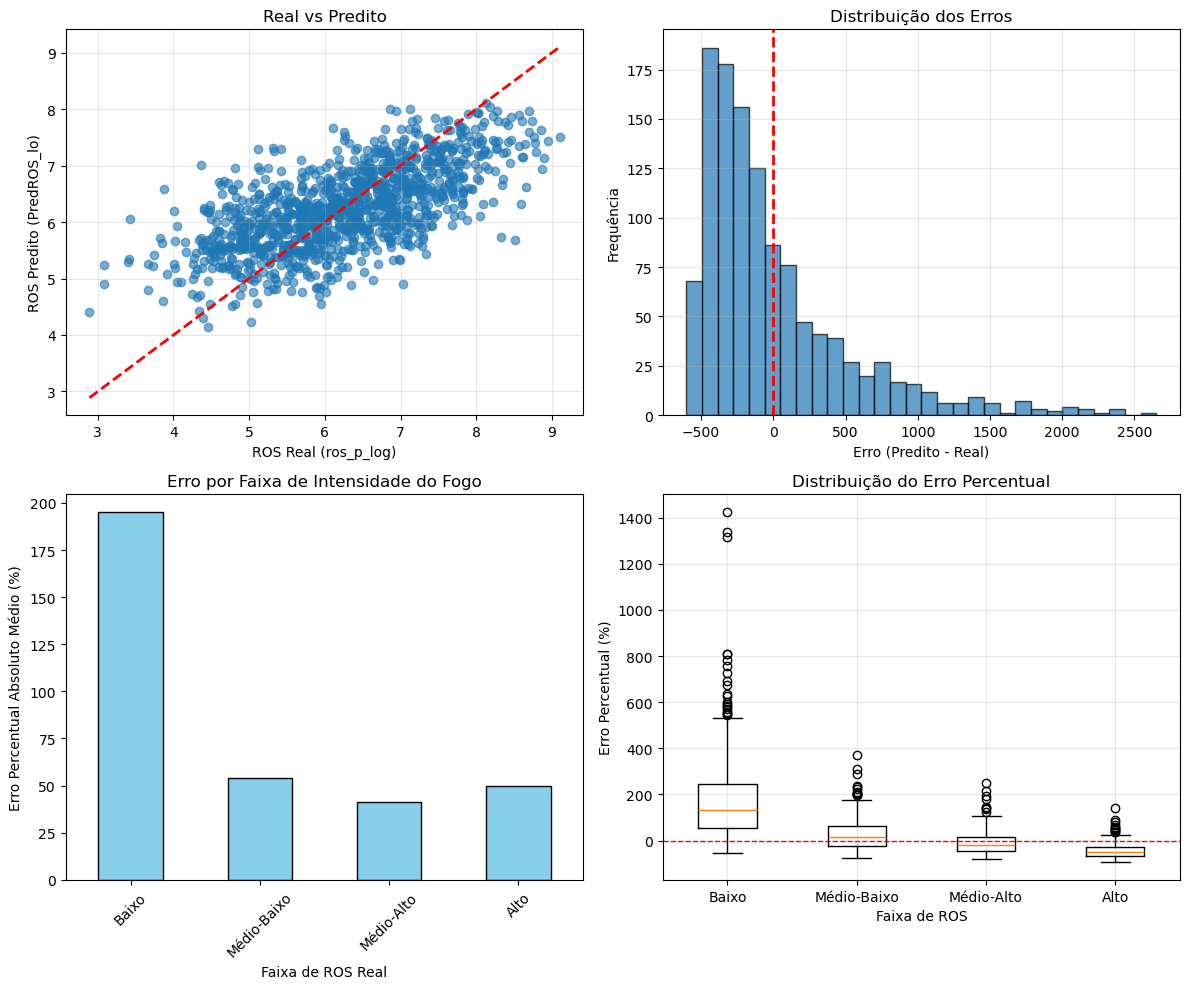

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def analyze_model_performance(df):
    """
    Análise geral da performance do modelo
    """
    # Calcular métricas principais
    mae = mean_absolute_error(df['ros_p_log'], df['PredROS_lo'])
    rmse = np.sqrt(mean_squared_error(df['ros_p_log'], df['PredROS_lo']))
    r2 = r2_score(df['ros_p_log'], df['PredROS_lo'])
    
    # Calcular bias (média dos erros)
    bias = df['PredDiff'].mean()
    
    # Calcular MAPE (Mean Absolute Percentage Error)
    # Evitar divisão por zero
    valid_mask = df['ros_p_log'] != 0
    mape = np.mean(np.abs(df.loc[valid_mask, 'Err_pct']))
    
    # Análise por faixas de valor real
    df['ros_bin'] = pd.qcut(df['ros_p_log'], q=4, labels=['Baixo', 'Médio-Baixo', 'Médio-Alto', 'Alto'])
    
    metrics_by_bin = df.groupby('ros_bin').agg({
        'Err_pct': 'mean',
        'Error_p_ab': 'mean',
        'PredDiff': ['mean', 'std']
    }).round(2)
    
    # Imprimir resultados
    print("="*60)
    print("ANÁLISE DE PERFORMANCE DO MODELO")
    print("="*60)
    print(f"\nMétricas Gerais:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}")
    print(f"Bias (Média Erro): {bias:.2f}")
    print(f"MAPE: {mape:.2f}%")
    
    print(f"\nDistribuição dos Erros:")
    print(f"Erro Médio: {df['PredDiff'].mean():.2f}")
    print(f"Desvio Padrão do Erro: {df['PredDiff'].std():.2f}")
    print(f"Mínimo Erro: {df['PredDiff'].min():.2f}")
    print(f"Máximo Erro: {df['PredDiff'].max():.2f}")
    
    print(f"\nPerformance por Faixa de ROS:")
    print(metrics_by_bin)
    
    # Visualizações
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Scatter plot: Real vs Predito
    ax1 = axes[0, 0]
    ax1.scatter(df['ros_p_log'], df['PredROS_lo'], alpha=0.6)
    ax1.plot([df['ros_p_log'].min(), df['ros_p_log'].max()], 
             [df['ros_p_log'].min(), df['ros_p_log'].max()], 'r--', lw=2)
    ax1.set_xlabel('ROS Real (ros_p_log)')
    ax1.set_ylabel('ROS Predito (PredROS_lo)')
    ax1.set_title('Real vs Predito')
    ax1.grid(True, alpha=0.3)
    
    # 2. Distribuição dos erros
    ax2 = axes[0, 1]
    ax2.hist(df['PredDiff'], bins=30, edgecolor='black', alpha=0.7)
    ax2.axvline(x=0, color='r', linestyle='--', linewidth=2)
    ax2.set_xlabel('Erro (Predito - Real)')
    ax2.set_ylabel('Frequência')
    ax2.set_title('Distribuição dos Erros')
    ax2.grid(True, alpha=0.3)
    
    # 3. Erro percentual por faixa de ROS
    ax3 = axes[1, 0]
    error_by_bin = df.groupby('ros_bin')['Error_p_ab'].mean()
    error_by_bin.plot(kind='bar', ax=ax3, color='skyblue', edgecolor='black')
    ax3.set_xlabel('Faixa de ROS Real')
    ax3.set_ylabel('Erro Percentual Absoluto Médio (%)')
    ax3.set_title('Erro por Faixa de Intensidade do Fogo')
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. Boxplot dos erros por faixa
    ax4 = axes[1, 1]
    box_data = [df[df['ros_bin'] == bin_val]['Err_pct'].values 
                for bin_val in df['ros_bin'].cat.categories]
    ax4.boxplot(box_data, labels=df['ros_bin'].cat.categories)
    ax4.axhline(y=0, color='r', linestyle='--', linewidth=1)
    ax4.set_xlabel('Faixa de ROS')
    ax4.set_ylabel('Erro Percentual (%)')
    ax4.set_title('Distribuição do Erro Percentual')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'bias': bias,
        'mape': mape,
        'metrics_by_bin': metrics_by_bin
    }

# Executar análise
metrics = analyze_model_performance(df)

ANÁLISE DE MÁS PREVISÕES

1. DISTRIBUIÇÃO DE PREVISÕES:
   Total de observações: 1173
   Boas previsões: 418 (35.6%)
   Más previsões: 755 (64.4%)

2. MÉTRICAS DE ERRO:
   MAE (todas): 386.18
   MAE (boas): 405.26
   MAE (más): 375.62

   MAPE (todas): 85.12%
   MAPE (boas): 18.36%
   MAPE (más): 122.08%

3. DISTRIBUIÇÃO DOS ERROS (%):
   Mínimo erro: -94.11%
   Máximo erro: 1426.46%
   Mediana erro: -1.31%
   IQR erro: 115.63%

4. ERROS EXTREMOS (>95º percentil = 291.4%):
   Número: 59
   Percentagem: 5.0%


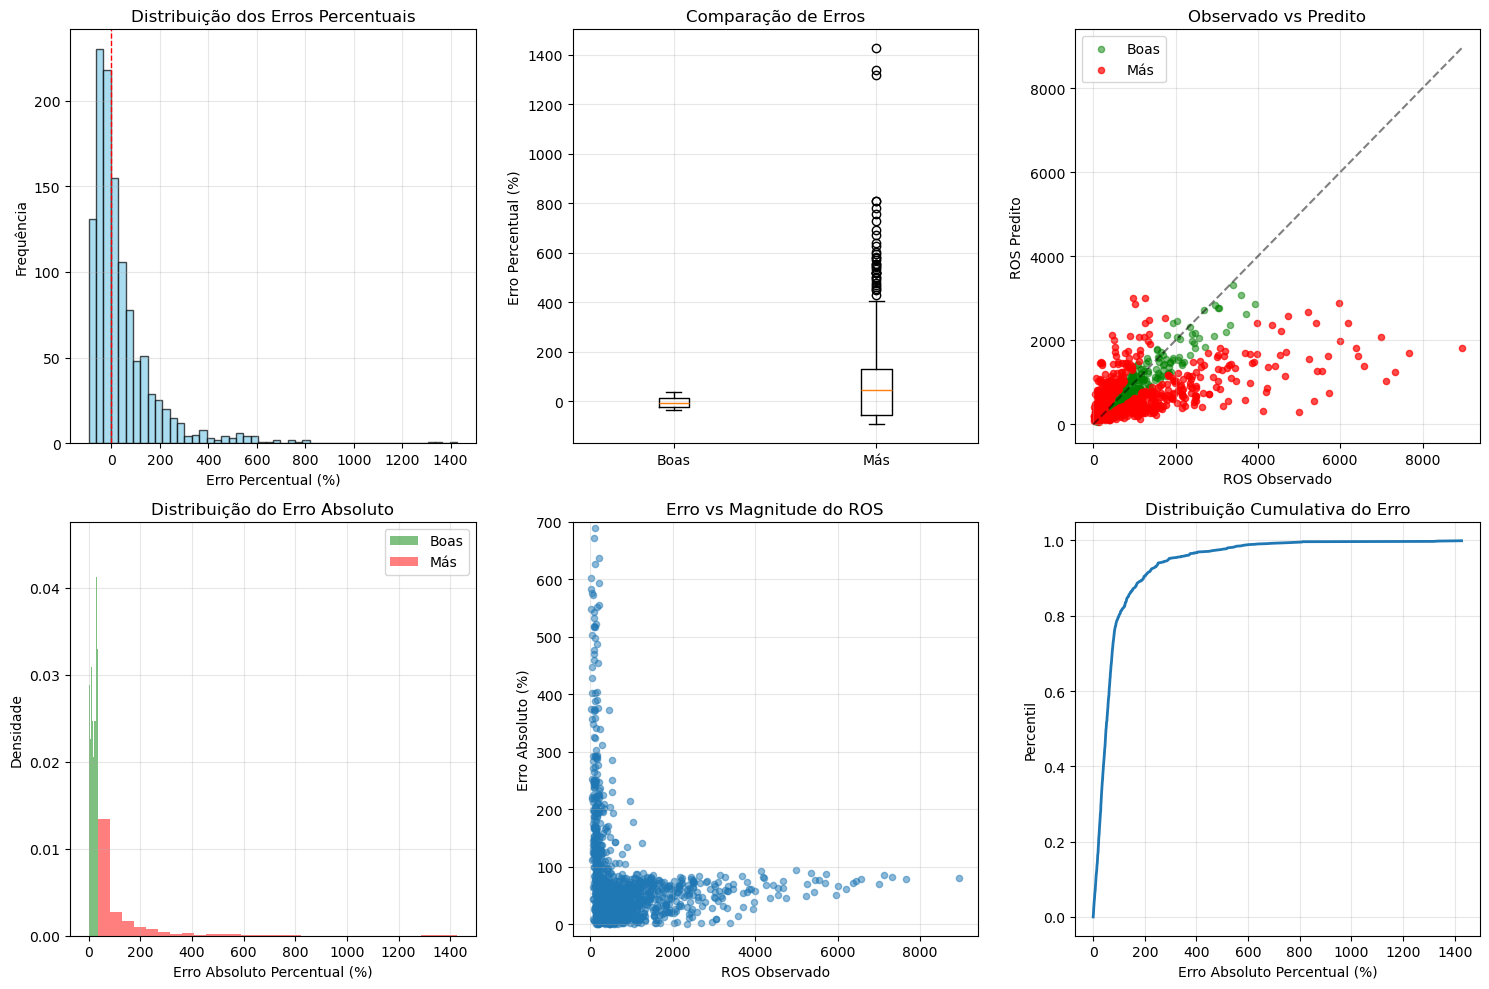


7. CORRELAÇÕES:

Correlação com erro absoluto:
   ros_p_log: -0.455


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def analyze_bad_predictions(df):
    """
    Análise descritiva das más previsões
    """
    # Filtrar apenas más previsões
    bad_preds = df[df['bad_pred'] == True].copy()
    good_preds = df[df['bad_pred'] == False].copy()
    
    print("=" * 80)
    print("ANÁLISE DE MÁS PREVISÕES")
    print("=" * 80)
    
    # Estatísticas básicas
    print(f"\n1. DISTRIBUIÇÃO DE PREVISÕES:")
    print(f"   Total de observações: {len(df)}")
    print(f"   Boas previsões: {len(good_preds)} ({len(good_preds)/len(df)*100:.1f}%)")
    print(f"   Más previsões: {len(bad_preds)} ({len(bad_preds)/len(df)*100:.1f}%)")
    
    # Métricas de erro
    print(f"\n2. MÉTRICAS DE ERRO:")
    print(f"   MAE (todas): {df['PredDiff'].abs().mean():.2f}")
    print(f"   MAE (boas): {good_preds['PredDiff'].abs().mean():.2f}")
    print(f"   MAE (más): {bad_preds['PredDiff'].abs().mean():.2f}")
    
    print(f"\n   MAPE (todas): {df['Error_p_ab'].mean():.2f}%")
    print(f"   MAPE (boas): {good_preds['Error_p_ab'].mean():.2f}%")
    print(f"   MAPE (más): {bad_preds['Error_p_ab'].mean():.2f}%")
    
    # Analisar distribuição dos erros
    print(f"\n3. DISTRIBUIÇÃO DOS ERROS (%):")
    print(f"   Mínimo erro: {df['Err_pct'].min():.2f}%")
    print(f"   Máximo erro: {df['Err_pct'].max():.2f}%")
    print(f"   Mediana erro: {df['Err_pct'].median():.2f}%")
    print(f"   IQR erro: {df['Err_pct'].quantile(0.75) - df['Err_pct'].quantile(0.25):.2f}%")
    
    # Valores extremos
    threshold_high_error = df['Error_p_ab'].quantile(0.95)
    extreme_errors = df[df['Error_p_ab'] > threshold_high_error]
    print(f"\n4. ERROS EXTREMOS (>95º percentil = {threshold_high_error:.1f}%):")
    print(f"   Número: {len(extreme_errors)}")
    print(f"   Percentagem: {len(extreme_errors)/len(df)*100:.1f}%")
    
    # Analisar por tipo de fogo
    if 'type' in df.columns:
        print(f"\n5. DISTRIBUIÇÃO POR TIPO:")
        for fire_type in df['type'].unique():
            type_data = df[df['type'] == fire_type]
            type_bad = bad_preds[bad_preds['type'] == fire_type]
            if len(type_data) > 0:
                perc_bad = len(type_bad)/len(type_data)*100
                print(f"   Tipo {fire_type}: {len(type_bad)}/{len(type_data)} ({perc_bad:.1f}%) más previsões")
    
    # Analisar por ano
    if 'year' in df.columns:
        print(f"\n6. DISTRIBUIÇÃO POR ANO:")
        for year in sorted(df['year'].unique()):
            year_data = df[df['year'] == year]
            year_bad = bad_preds[bad_preds['year'] == year]
            if len(year_data) > 0:
                perc_bad = len(year_bad)/len(year_data)*100
                print(f"   {year}: {len(year_bad)}/{len(year_data)} ({perc_bad:.1f}%) más previsões")
    
    return bad_preds, good_preds

# Visualização dos resultados
def plot_error_analysis(df, bad_preds, good_preds):
    """
    Visualização da análise de erros
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # 1. Histograma dos erros percentuais
    axes[0, 0].hist(df['Err_pct'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=1)
    axes[0, 0].set_xlabel('Erro Percentual (%)')
    axes[0, 0].set_ylabel('Frequência')
    axes[0, 0].set_title('Distribuição dos Erros Percentuais')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Boxplot comparativo
    error_data = [good_preds['Err_pct'].values, bad_preds['Err_pct'].values]
    axes[0, 1].boxplot(error_data, labels=['Boas', 'Más'])
    axes[0, 1].set_ylabel('Erro Percentual (%)')
    axes[0, 1].set_title('Comparação de Erros')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Scatter plot: Observado vs Predito
    axes[0, 2].scatter(good_preds['ros_p'], good_preds['PredROS_li'], 
                       alpha=0.5, color='green', label='Boas', s=20)
    axes[0, 2].scatter(bad_preds['ros_p'], bad_preds['PredROS_li'], 
                       alpha=0.7, color='red', label='Más', s=20)
    
    # Linha de perfeita previsão
    max_val = max(df['ros_p'].max(), df['PredROS_li'].max())
    axes[0, 2].plot([0, max_val], [0, max_val], 'k--', alpha=0.5)
    
    axes[0, 2].set_xlabel('ROS Observado')
    axes[0, 2].set_ylabel('ROS Predito')
    axes[0, 2].set_title('Observado vs Predito')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Distribuição do erro absoluto
    axes[1, 0].hist(good_preds['Error_p_ab'], bins=30, alpha=0.5, 
                    color='green', label='Boas', density=True)
    axes[1, 0].hist(bad_preds['Error_p_ab'], bins=30, alpha=0.5, 
                    color='red', label='Más', density=True)
    axes[1, 0].set_xlabel('Erro Absoluto Percentual (%)')
    axes[1, 0].set_ylabel('Densidade')
    axes[1, 0].set_title('Distribuição do Erro Absoluto')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Erro vs Valor Observado
    axes[1, 1].scatter(df['ros_p'], df['Error_p_ab'], alpha=0.5, s=20)
    axes[1, 1].set_xlabel('ROS Observado')
    axes[1, 1].set_ylabel('Erro Absoluto (%)')
    axes[1, 1].set_title('Erro vs Magnitude do ROS')
    axes[1, 1].set_ylim(-20,700)
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Distribuição cumulativa
    sorted_errors = np.sort(df['Error_p_ab'])
    y_vals = np.arange(len(sorted_errors)) / float(len(sorted_errors))
    axes[1, 2].plot(sorted_errors, y_vals, linewidth=2)
    axes[1, 2].set_xlabel('Erro Absoluto Percentual (%)')
    axes[1, 2].set_ylabel('Percentil')
    axes[1, 2].set_title('Distribuição Cumulativa do Erro')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Métricas adicionais
    print("\n7. CORRELAÇÕES:")
    corr_with_error = df[['ros_p_log', 'PredROS_lo', 'Error_p_ab'] + 
                        ['duration_p', '3_8y_fir_p', 'wv100_k_av', 
                         'f_load_av', 'FWI_12h_av', 'rh_2m_av', 
                         '8_ny_fir_p', 'f_start', 'wdi_950_av']].corr()['Error_p_ab']
    
    print("\nCorrelação com erro absoluto:")
    for var, corr in corr_with_error.items():
        if var != 'Error_p_ab' and abs(corr) > 0.1:
            print(f"   {var}: {corr:.3f}")


bad_preds, good_preds = analyze_bad_predictions(df)
plot_error_analysis(df, bad_preds, good_preds)

Total observações: 1173
Bad preds encontradas: 755
Good preds encontradas: 418
ANÁLISE DOS VALORES SHAP

duration_p (shap_durat):
  SHAP médio (más): 0.0441
  SHAP médio (boas): 0.1486
  |SHAP| médio (más): 1.4680
  |SHAP| médio (boas): 1.3825

3_8y_fir_p (shap_3_8y_):
  SHAP médio (más): -0.0069
  SHAP médio (boas): 0.0000
  |SHAP| médio (más): 0.2245
  |SHAP| médio (boas): 0.2260

HDW_av (shap_HDW_a):
  SHAP médio (más): 331.0234
  SHAP médio (boas): 804.8303
  |SHAP| médio (más): 3397.9734
  |SHAP| médio (boas): 3567.6930

Dados para plotagem:
  Bad preds: 755 observações
  Good preds: 418 observações

duration_p vs shap_durat:
  Good: 418 pontos | Bad: 755 pontos

3_8y_fir_p vs shap_3_8y_:
  Good: 418 pontos | Bad: 755 pontos
AVISO: SHAP shap_sW_10 não encontrado

HDW_av vs shap_HDW_a:
  Good: 418 pontos | Bad: 755 pontos
AVISO: SHAP shap_8_ny_ não encontrado
AVISO: SHAP shap_f_sta não encontrado


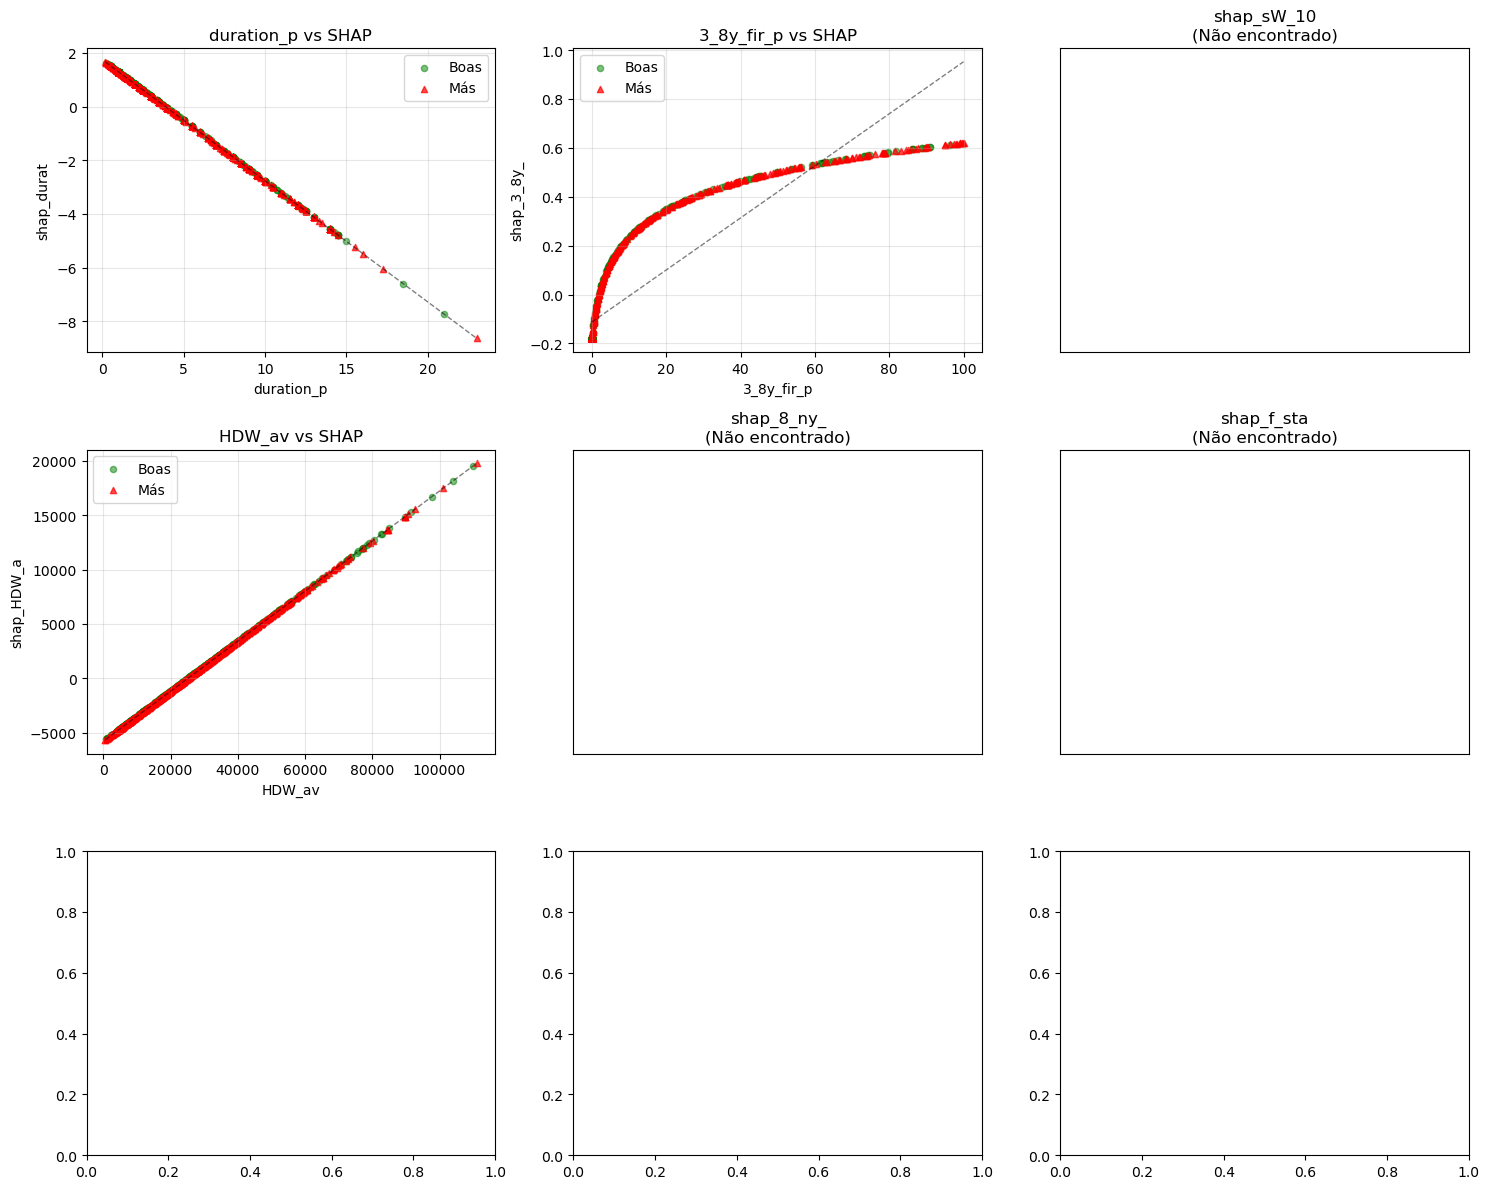

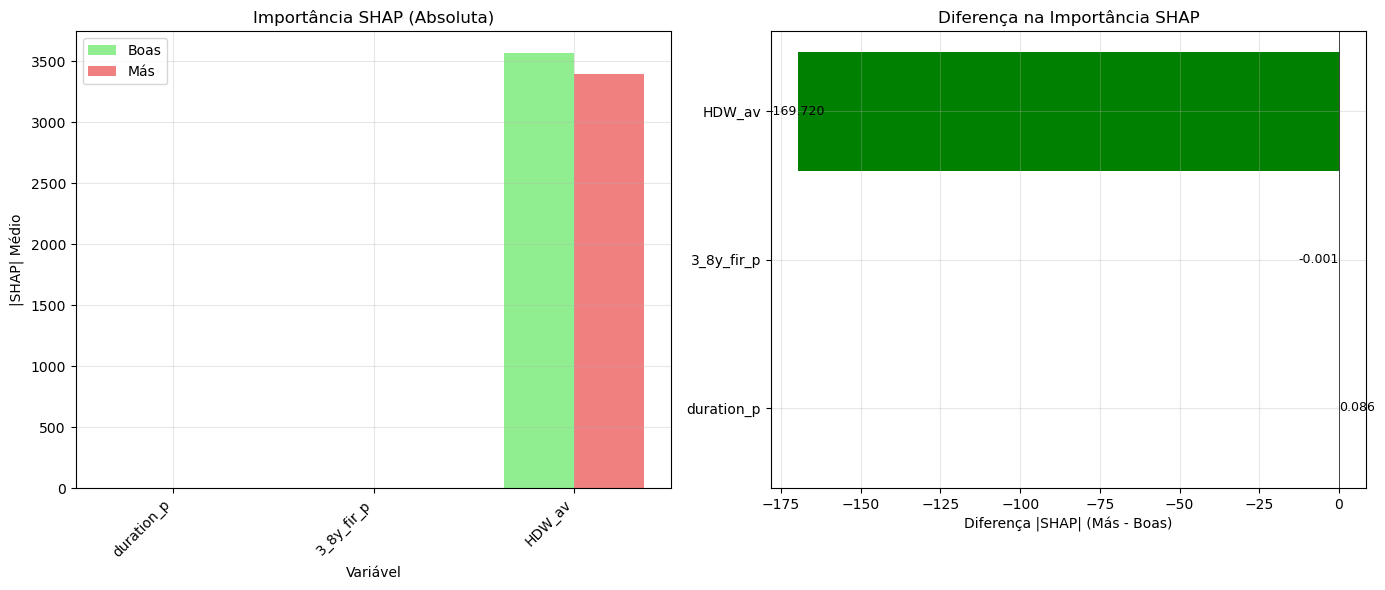

In [22]:
def analyze_shap_values(df):
    """
    Análise dos valores SHAP para más previsões
    """
    # Se bad_pred for string 'True'/'False', converter
    if df['bad_pred'].dtype == 'object':
        bad_preds = df[df['bad_pred'] == 'True'].copy()
        good_preds = df[df['bad_pred'] == 'False'].copy()
    else:
        # Se já for booleano
        bad_preds = df[df['bad_pred'] == True].copy()
        good_preds = df[df['bad_pred'] == False].copy()
    
    print(f"Total observações: {len(df)}")
    print(f"Bad preds encontradas: {len(bad_preds)}")
    print(f"Good preds encontradas: {len(good_preds)}")
    
    # Mapeamento de variáveis para SHAP
    var_to_shap = {
        'duration_p': 'shap_durat',
        '3_8y_fir_p': 'shap_3_8y_',
        'sW_100_av': 'shap_sW_10',
        'HDW_av': 'shap_HDW_a',
        '8_ny_fir_p': 'shap_8_ny_',
        'f_start': 'shap_f_sta',
    }

    
    print("=" * 80)
    print("ANÁLISE DOS VALORES SHAP")
    print("=" * 80)
    
    shap_results = {}
    
    for var, shap_var in var_to_shap.items():
        if shap_var in df.columns and var in df.columns:
            # Verificar se há dados
            if len(bad_preds) == 0 or len(good_preds) == 0:
                print(f"\nATENÇÃO: Sem dados para {var}")
                continue
            
            # Valores SHAP médios
            bad_shap_mean = bad_preds[shap_var].mean()
            good_shap_mean = good_preds[shap_var].mean()
            bad_shap_abs_mean = bad_preds[shap_var].abs().mean()
            good_shap_abs_mean = good_preds[shap_var].abs().mean()
            
            shap_results[var] = {
                'bad_shap_mean': bad_shap_mean,
                'good_shap_mean': good_shap_mean,
                'bad_shap_abs_mean': bad_shap_abs_mean,
                'good_shap_abs_mean': good_shap_abs_mean,
                'shap_diff': bad_shap_abs_mean - good_shap_abs_mean
            }
            
            print(f"\n{var} ({shap_var}):")
            print(f"  SHAP médio (más): {bad_shap_mean:.4f}")
            print(f"  SHAP médio (boas): {good_shap_mean:.4f}")
            print(f"  |SHAP| médio (más): {bad_shap_abs_mean:.4f}")
            print(f"  |SHAP| médio (boas): {good_shap_abs_mean:.4f}")
    
    return shap_results

def plot_shap_analysis(df, shap_results):
    """
    Visualização da análise SHAP
    """
    # Converter se necessário
    if df['bad_pred'].dtype == 'object':
        bad_preds = df[df['bad_pred'] == 'True'].copy()
        good_preds = df[df['bad_pred'] == 'False'].copy()
    else:
        bad_preds = df[df['bad_pred'] == True].copy()
        good_preds = df[df['bad_pred'] == False].copy()
    
    print(f"\nDados para plotagem:")
    print(f"  Bad preds: {len(bad_preds)} observações")
    print(f"  Good preds: {len(good_preds)} observações")
    
    var_to_shap = {
        'duration_p': 'shap_durat',
        '3_8y_fir_p': 'shap_3_8y_',
        'sW_100_av': 'shap_sW_10',
        'HDW_av': 'shap_HDW_a',
        '8_ny_fir_p': 'shap_8_ny_',
        'f_start': 'shap_f_sta',
    }
    
    
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, (var, shap_var) in enumerate(var_to_shap.items()):
        if i < len(axes):
            # VERIFICAÇÃO CRÍTICA: ambas as colunas existem?
            if var not in df.columns:
                print(f"AVISO: Variável {var} não encontrada")
                axes[i].set_title(f'{var}\n(Não encontrada)')
                axes[i].set_xticks([])
                axes[i].set_yticks([])
                continue
            
            if shap_var not in df.columns:
                print(f"AVISO: SHAP {shap_var} não encontrado")
                axes[i].set_title(f'{shap_var}\n(Não encontrado)')
                axes[i].set_xticks([])
                axes[i].set_yticks([])
                continue
            
            # Verificar se há dados para plotar
            good_data = good_preds[[var, shap_var]].dropna()
            bad_data = bad_preds[[var, shap_var]].dropna()
            
            print(f"\n{var} vs {shap_var}:")
            print(f"  Good: {len(good_data)} pontos | Bad: {len(bad_data)} pontos")
            
            if len(good_data) > 0:
                axes[i].scatter(good_data[var], good_data[shap_var], 
                              alpha=0.5, color='green', label='Boas', s=20)
            
            if len(bad_data) > 0:
                axes[i].scatter(bad_data[var], bad_data[shap_var], 
                              alpha=0.7, color='red', label='Más', s=20, marker='^')
            
            axes[i].set_xlabel(var)
            axes[i].set_ylabel(shap_var)
            axes[i].set_title(f'{var} vs SHAP')
            axes[i].grid(True, alpha=0.3)
            
            # Adicionar legenda apenas se houver dados
            if len(good_data) > 0 or len(bad_data) > 0:
                axes[i].legend()
            
            # Linha de tendência
            all_data = df[[var, shap_var]].dropna()
            if len(all_data) > 10:  # Mínimo para calcular tendência
                try:
                    x = all_data[var].values
                    y = all_data[shap_var].values
                    if len(np.unique(x)) > 1:
                        z = np.polyfit(x, y, 1)
                        p = np.poly1d(z)
                        x_range = np.linspace(x.min(), x.max(), 100)
                        axes[i].plot(x_range, p(x_range), 'k--', alpha=0.5, linewidth=1)
                except:
                    pass
    
    plt.tight_layout()
    plt.show()
    
    # Plot importância SHAP comparativa
    if shap_results and len(shap_results) > 0:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # SHAP médios absolutos
        variables = list(shap_results.keys())
        bad_shap_abs = [shap_results[var]['bad_shap_abs_mean'] for var in variables]
        good_shap_abs = [shap_results[var]['good_shap_abs_mean'] for var in variables]
        
        x = np.arange(len(variables))
        width = 0.35
        
        ax1.bar(x - width/2, good_shap_abs, width, label='Boas', color='lightgreen')
        ax1.bar(x + width/2, bad_shap_abs, width, label='Más', color='lightcoral')
        
        ax1.set_xlabel('Variável')
        ax1.set_ylabel('|SHAP| Médio')
        ax1.set_title('Importância SHAP (Absoluta)')
        ax1.set_xticks(x)
        ax1.set_xticklabels(variables, rotation=45, ha='right')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Diferenças de SHAP
        shap_diffs = [shap_results[var]['shap_diff'] for var in variables]
        colors = ['red' if diff > 0 else 'green' for diff in shap_diffs]
        
        ax2.barh(variables, shap_diffs, color=colors)
        ax2.set_xlabel('Diferença |SHAP| (Más - Boas)')
        ax2.set_title('Diferença na Importância SHAP')
        ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        ax2.grid(True, alpha=0.3)
        
        # Adicionar valores
        for j, diff in enumerate(shap_diffs):
            ax2.text(diff * 1.05 if diff >= 0 else diff * 0.95, 
                    j, f'{diff:.3f}', va='center',
                    ha='left' if diff >= 0 else 'right', fontsize=9)
        
        plt.tight_layout()
        plt.show()

shap_results = analyze_shap_values(df)
plot_shap_analysis(df, shap_results)

ANÁLISE DE RESÍDUOS E VIÉS


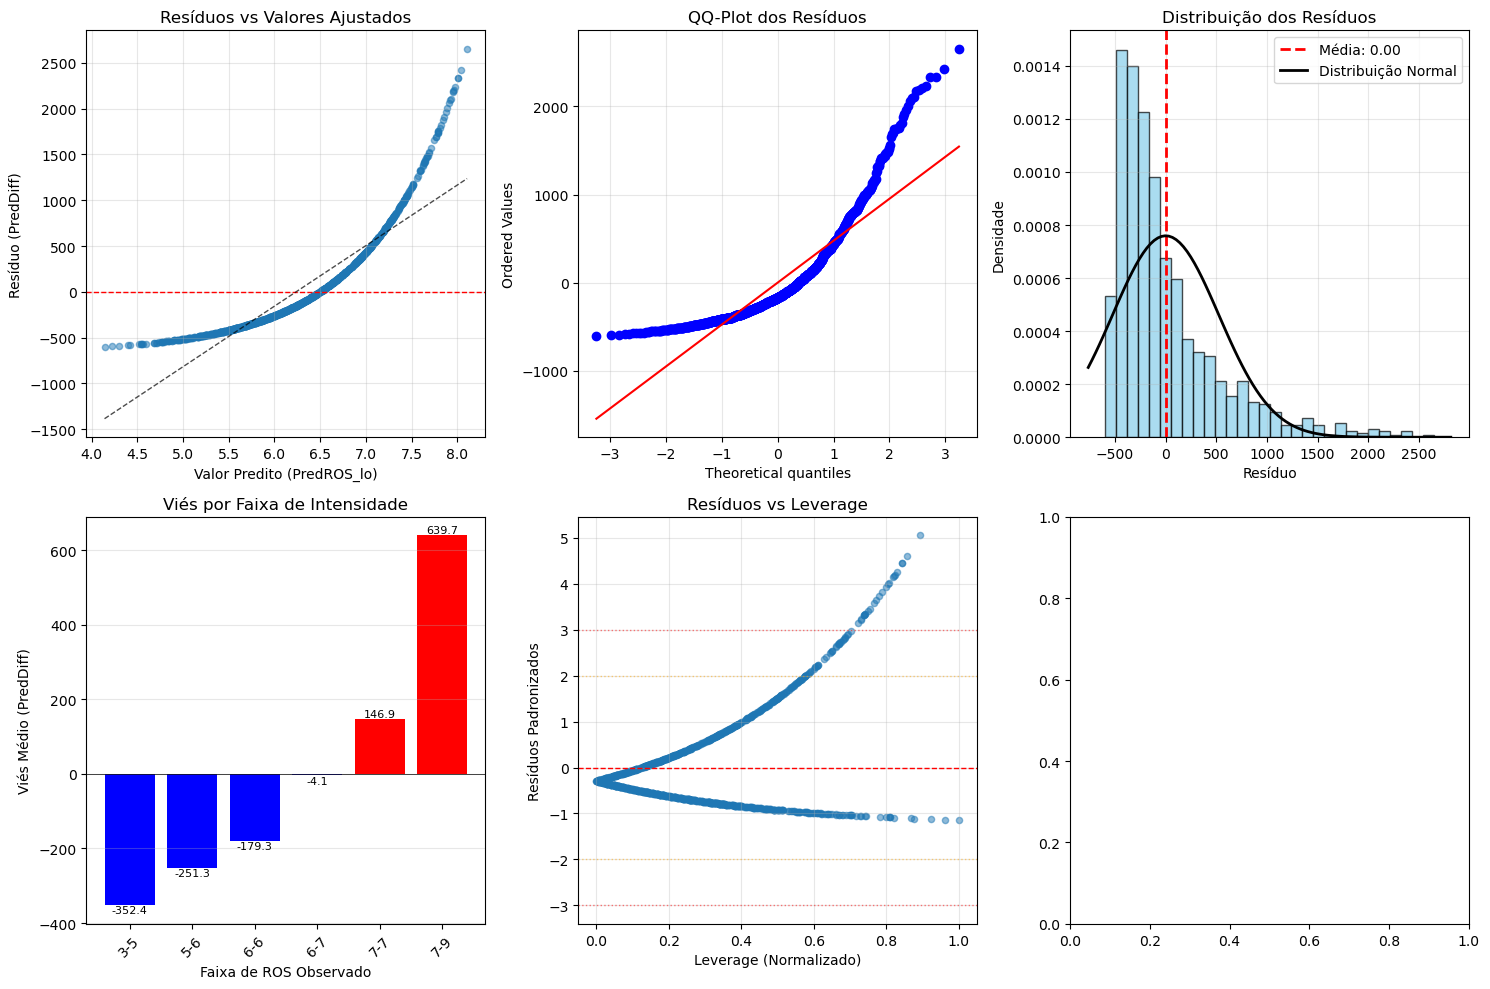


ESTATÍSTICAS DOS RESÍDUOS:
  Média: 0.000
  Desvio Padrão: 525.508
  Skewness: 1.835
  Kurtosis: 3.839
  Teste de Normalidade (Shapiro-Wilk):
    Estatística: 0.8178, p-value: 0.0000
    Normal? NÃO


In [23]:
def analyze_residuals_and_bias(df):
    """
    Análise detalhada dos resíduos e viés do modelo
    """
    print("=" * 80)
    print("ANÁLISE DE RESÍDUOS E VIÉS")
    print("=" * 80)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # 1. Resíduos vs Valores Ajustados
    axes[0, 0].scatter(df['PredROS_lo'], df['PredDiff'], alpha=0.5, s=20)
    axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=1)
    axes[0, 0].set_xlabel('Valor Predito (PredROS_lo)')
    axes[0, 0].set_ylabel('Resíduo (PredDiff)')
    axes[0, 0].set_title('Resíduos vs Valores Ajustados')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Adicionar linha de tendência
    if len(df) > 1:
        z = np.polyfit(df['PredROS_lo'], df['PredDiff'], 1)
        p = np.poly1d(z)
        x_range = np.linspace(df['PredROS_lo'].min(), df['PredROS_lo'].max(), 100)
        axes[0, 0].plot(x_range, p(x_range), 'k--', alpha=0.7, linewidth=1)
    
    # 2. QQ-Plot dos Resíduos
    if len(df) > 0:
        residuals = df['PredDiff'].dropna()
        if len(residuals) > 0:
            stats.probplot(residuals, dist="norm", plot=axes[0, 1])
            axes[0, 1].set_title('QQ-Plot dos Resíduos')
            axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Histograma dos Resíduos
    axes[0, 2].hist(df['PredDiff'], bins=30, alpha=0.7, color='skyblue', edgecolor='black', density=True)
    axes[0, 2].axvline(x=df['PredDiff'].mean(), color='red', linestyle='--', linewidth=2, label=f'Média: {df["PredDiff"].mean():.2f}')
    axes[0, 2].set_xlabel('Resíduo')
    axes[0, 2].set_ylabel('Densidade')
    axes[0, 2].set_title('Distribuição dos Resíduos')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Adicionar curva normal
    if len(df) > 1:
        mu, std = stats.norm.fit(df['PredDiff'].dropna())
        xmin, xmax = axes[0, 2].get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = stats.norm.pdf(x, mu, std)
        axes[0, 2].plot(x, p, 'k', linewidth=2, label='Distribuição Normal')
        axes[0, 2].legend()
    
    # 4. Viés por Faixa de ROS
    if 'ros_p_log' in df.columns:
        # Criar bins
        ros_bins = pd.qcut(df['ros_p_log'], q=6, duplicates='drop')
        df['ros_bin_q'] = ros_bins
        
        # Calcular viés médio por bin
        bias_by_bin = []
        bin_labels = []
        
        for bin_cat in df['ros_bin_q'].cat.categories:
            bin_data = df[df['ros_bin_q'] == bin_cat]
            if len(bin_data) > 0:
                bias = bin_data['PredDiff'].mean()
                bias_by_bin.append(bias)
                # Formatar label
                label = f'{bin_cat.left:.0f}-{bin_cat.right:.0f}'
                bin_labels.append(label)
        
        # Plot
        colors = ['red' if b > 0 else 'blue' for b in bias_by_bin]
        bars = axes[1, 0].bar(bin_labels, bias_by_bin, color=colors)
        axes[1, 0].axhline(y=0, color='black', linewidth=0.5)
        axes[1, 0].set_xlabel('Faixa de ROS Observado')
        axes[1, 0].set_ylabel('Viés Médio (PredDiff)')
        axes[1, 0].set_title('Viés por Faixa de Intensidade')
        axes[1, 0].tick_params(axis='x', rotation=45)
        axes[1, 0].grid(True, alpha=0.3, axis='y')
        
        # Adicionar valores
        for bar, bias in zip(bars, bias_by_bin):
            height = bar.get_height()
            axes[1, 0].text(bar.get_x() + bar.get_width()/2., 
                           height + (0.1 if height >= 0 else -0.3),
                           f'{bias:.1f}', ha='center', va='bottom' if height >= 0 else 'top', fontsize=8)
    
    # 5. Resíduos Padronizados vs Leverage (Cook's Distance aproximada)
    if len(df) > 1:
        # Calcular resíduos padronizados
        residuals = df['PredDiff'].values
        std_residuals = residuals / np.std(residuals)
        
        # Calcular leverage aproximado (baseado em distância ao centróide das predições)
        pred_mean = df['PredROS_lo'].mean()
        leverage = np.abs(df['PredROS_lo'] - pred_mean)
        leverage = leverage / leverage.max()  # Normalizar
        
        axes[1, 1].scatter(leverage, std_residuals, alpha=0.5, s=20)
        axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=1)
        axes[1, 1].axhline(y=2, color='orange', linestyle=':', linewidth=1, alpha=0.5)
        axes[1, 1].axhline(y=-2, color='orange', linestyle=':', linewidth=1, alpha=0.5)
        axes[1, 1].axhline(y=3, color='red', linestyle=':', linewidth=1, alpha=0.5)
        axes[1, 1].axhline(y=-3, color='red', linestyle=':', linewidth=1, alpha=0.5)
        
        axes[1, 1].set_xlabel('Leverage (Normalizado)')
        axes[1, 1].set_ylabel('Resíduos Padronizados')
        axes[1, 1].set_title('Resíduos vs Leverage')
        axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Auto-correlação dos Resíduos (se houver ordem temporal)
    if 'sdate' in df.columns and len(df) > 10:
        try:
            # Ordenar por data
            df_sorted = df.copy()
            df_sorted['date'] = pd.to_datetime(df_sorted['sdate'])
            df_sorted = df_sorted.sort_values('date')
            
            # Calcular autocorrelação
            residuals_sorted = df_sorted['PredDiff'].values
            n_lags = min(20, len(residuals_sorted) - 1)
            
            if n_lags > 0:
                autocorr = [1.0]  # Lag 0
                for lag in range(1, n_lags + 1):
                    autocorr.append(np.corrcoef(residuals_sorted[:-lag], residuals_sorted[lag:])[0, 1])
                
                lags = range(n_lags + 1)
                axes[1, 2].bar(lags, autocorr, width=0.3, color='steelblue')
                axes[1, 2].axhline(y=0, color='black', linewidth=0.5)
                
                # Adicionar bandas de confiança (aproximadas)
                conf_level = 1.96 / np.sqrt(len(residuals_sorted))
                axes[1, 2].axhline(y=conf_level, color='red', linestyle='--', alpha=0.5, linewidth=1)
                axes[1, 2].axhline(y=-conf_level, color='red', linestyle='--', alpha=0.5, linewidth=1)
                
                axes[1, 2].set_xlabel('Lag')
                axes[1, 2].set_ylabel('Autocorrelação')
                axes[1, 2].set_title('Autocorrelação dos Resíduos')
                axes[1, 2].grid(True, alpha=0.3, axis='y')
        except:
            axes[1, 2].text(0.5, 0.5, 'Não foi possível\ncalcular autocorrelação',
                           ha='center', va='center', transform=axes[1, 2].transAxes)
    
    plt.tight_layout()
    plt.show()
    
    # Estatísticas dos resíduos
    print("\nESTATÍSTICAS DOS RESÍDUOS:")
    print(f"  Média: {df['PredDiff'].mean():.3f}")
    print(f"  Desvio Padrão: {df['PredDiff'].std():.3f}")
    print(f"  Skewness: {stats.skew(df['PredDiff'].dropna()):.3f}")
    print(f"  Kurtosis: {stats.kurtosis(df['PredDiff'].dropna()):.3f}")
    print(f"  Teste de Normalidade (Shapiro-Wilk):")
    if len(df) > 3 and len(df) < 5000:
        stat, p_value = stats.shapiro(df['PredDiff'].dropna())
        print(f"    Estatística: {stat:.4f}, p-value: {p_value:.4f}")
        print(f"    Normal? {'SIM' if p_value > 0.05 else 'NÃO'}")

analyze_residuals_and_bias(df)

MODEL SENSITIVITY ANALYSIS (P90)


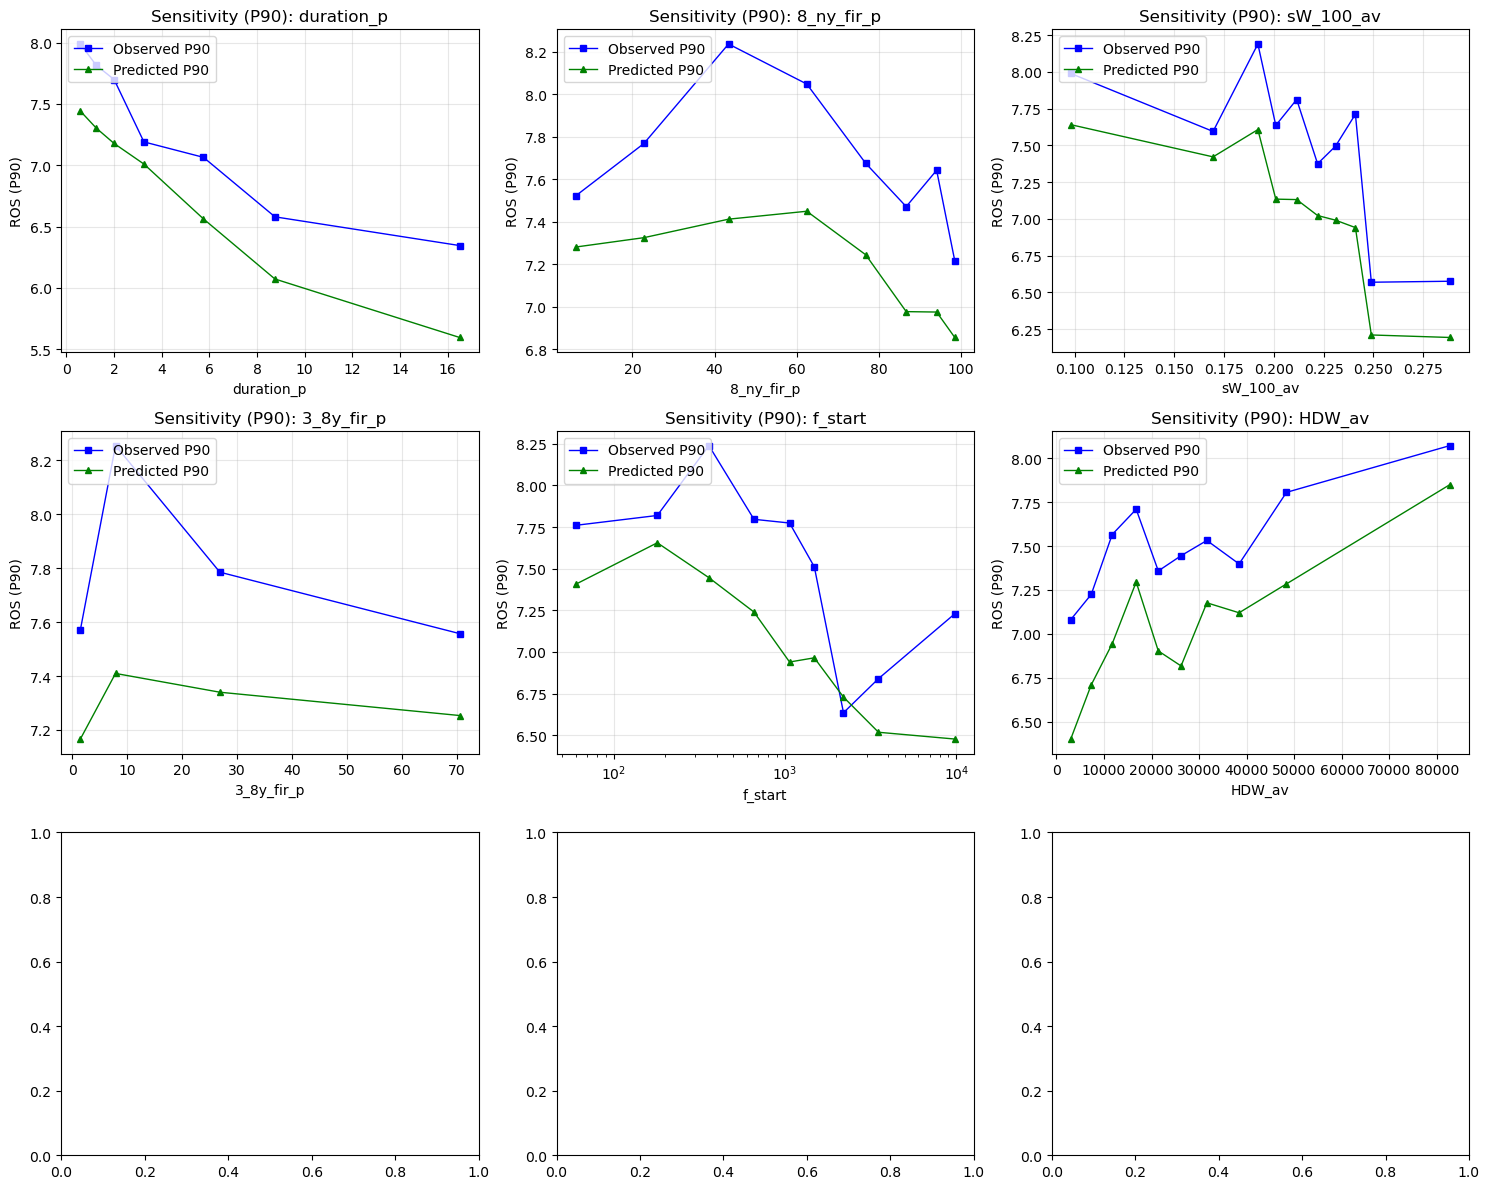

In [24]:
def analyze_model_sensitivity(df):
    """
    Model sensitivity analysis to predictor variables (using P90 of ROS)
    """
    print("=" * 80)
    print("MODEL SENSITIVITY ANALYSIS (P90)")
    print("=" * 80)
    
    predictor_vars = ['duration_p', '8_ny_fir_p', 'sW_100_av', '3_8y_fir_p', 'f_start', 'HDW_av']
    
    # Keep only variables present in the dataframe
    predictor_vars = [v for v in predictor_vars if v in df.columns]
    
    if not predictor_vars:
        print("No predictor variables found in the dataframe.")
        return
    
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, var in enumerate(predictor_vars[:9]):
        if i < len(axes):
            if len(df[var].dropna()) > 0:
                bins = pd.qcut(df[var], q=10, duplicates='drop')
                
                pred_by_bin = []
                obs_by_bin = []
                bin_centers = []
                
                for bin_cat in bins.cat.categories:
                    bin_mask = bins == bin_cat
                    bin_data = df[bin_mask]
                    
                    if len(bin_data) > 0:
                        pred_by_bin.append(bin_data['PredROS_lo'].quantile(0.9))
                        obs_by_bin.append(bin_data['ros_p_log'].quantile(0.9))
                        bin_centers.append((bin_cat.left + bin_cat.right) / 2)
                
                ax = axes[i]
                ax.plot(bin_centers, obs_by_bin, 's-', linewidth=1, markersize=4,
                        color='blue', label='Observed P90')
                ax.plot(bin_centers, pred_by_bin, '^-', linewidth=1, markersize=4,
                        color='green', label='Predicted P90')
                
                ax.set_xlabel(var)
                ax.set_ylabel('ROS (P90)')
                ax.set_title(f'Sensitivity (P90): {var}')
                ax.grid(True, alpha=0.3)
                ax.legend(loc='upper left')

                               
                if var == 'f_start':
                    ax.set_xscale('log')

    
    plt.tight_layout()
    plt.show()




analyze_model_sensitivity(df)

ANÁLISE COMPLETA DE TODAS AS INTERAÇÕES COM HEATMAPS
Variáveis preditoras disponíveis: ['duration_p', '3_8y_fir_p', 'f_load_av', 'FWI_12h_av', '8_ny_fir_p', 'f_start']
Número total de combinações: 15

Calculando interações para todos os pares...
  Processando 15/15: 8_ny_fir_p × f_startr_p

Interações válidas encontradas: 15
Média de observações por par: 1173
Média de células com dados: 18.5

GERANDO HEATMAPS PARA TODAS AS INTERAÇÕES

Criando 4x4 grid com 15 heatmaps...


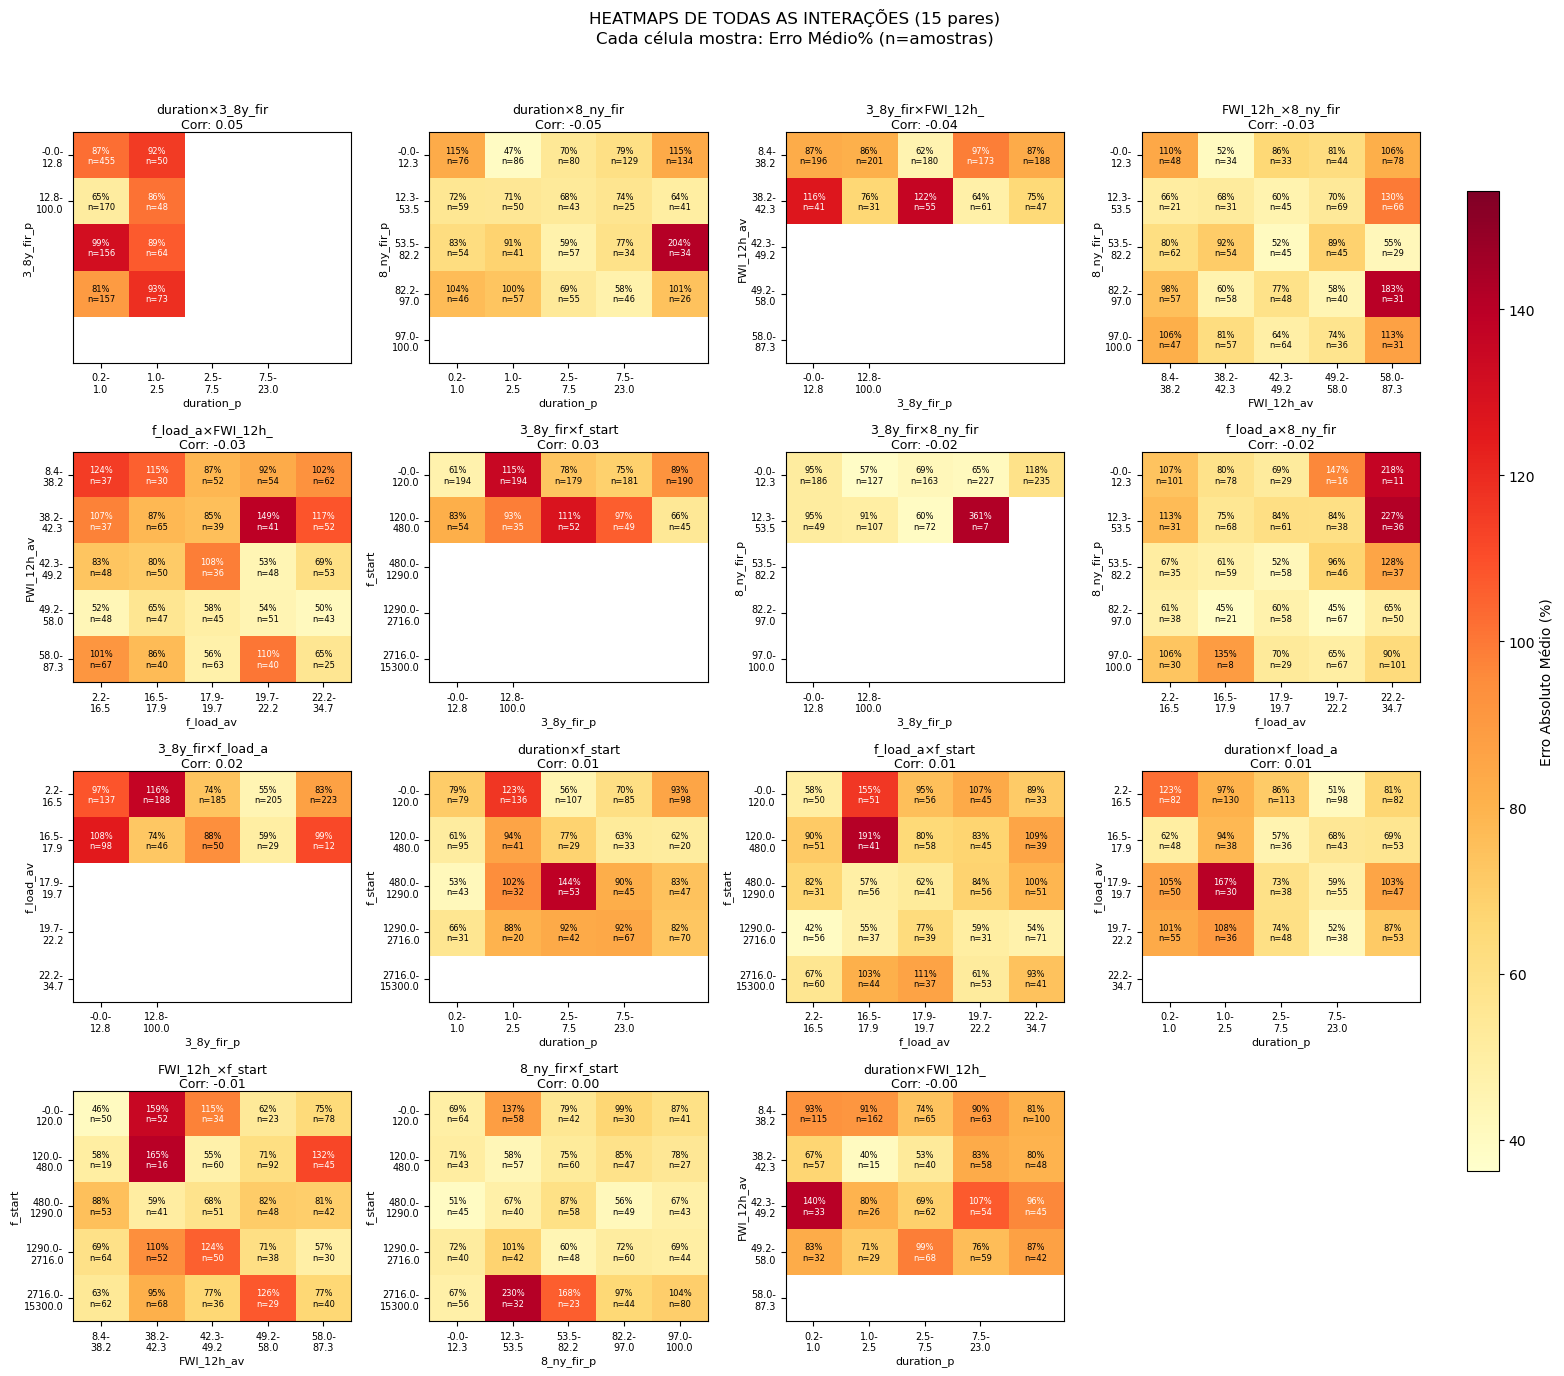


HEATMAPS ADICIONAIS: ROS OBSERVADO vs PREDITO


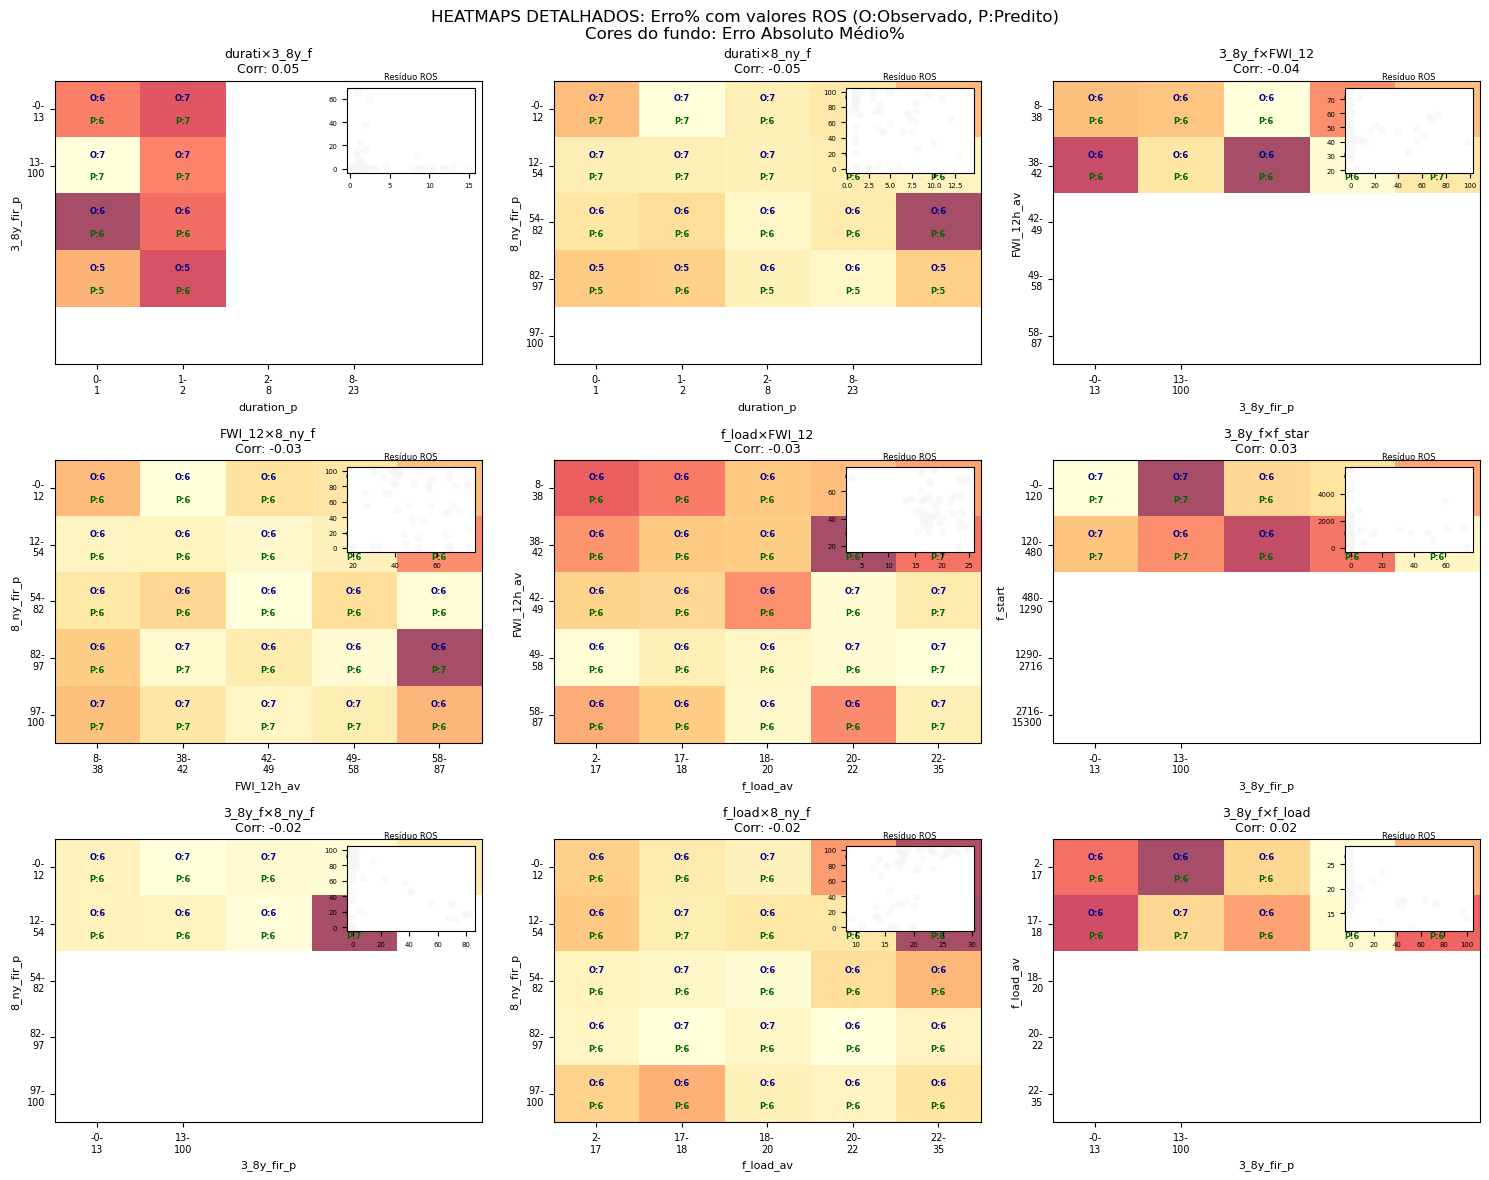


ANÁLISE ESTATÍSTICA DAS INTERAÇÕES


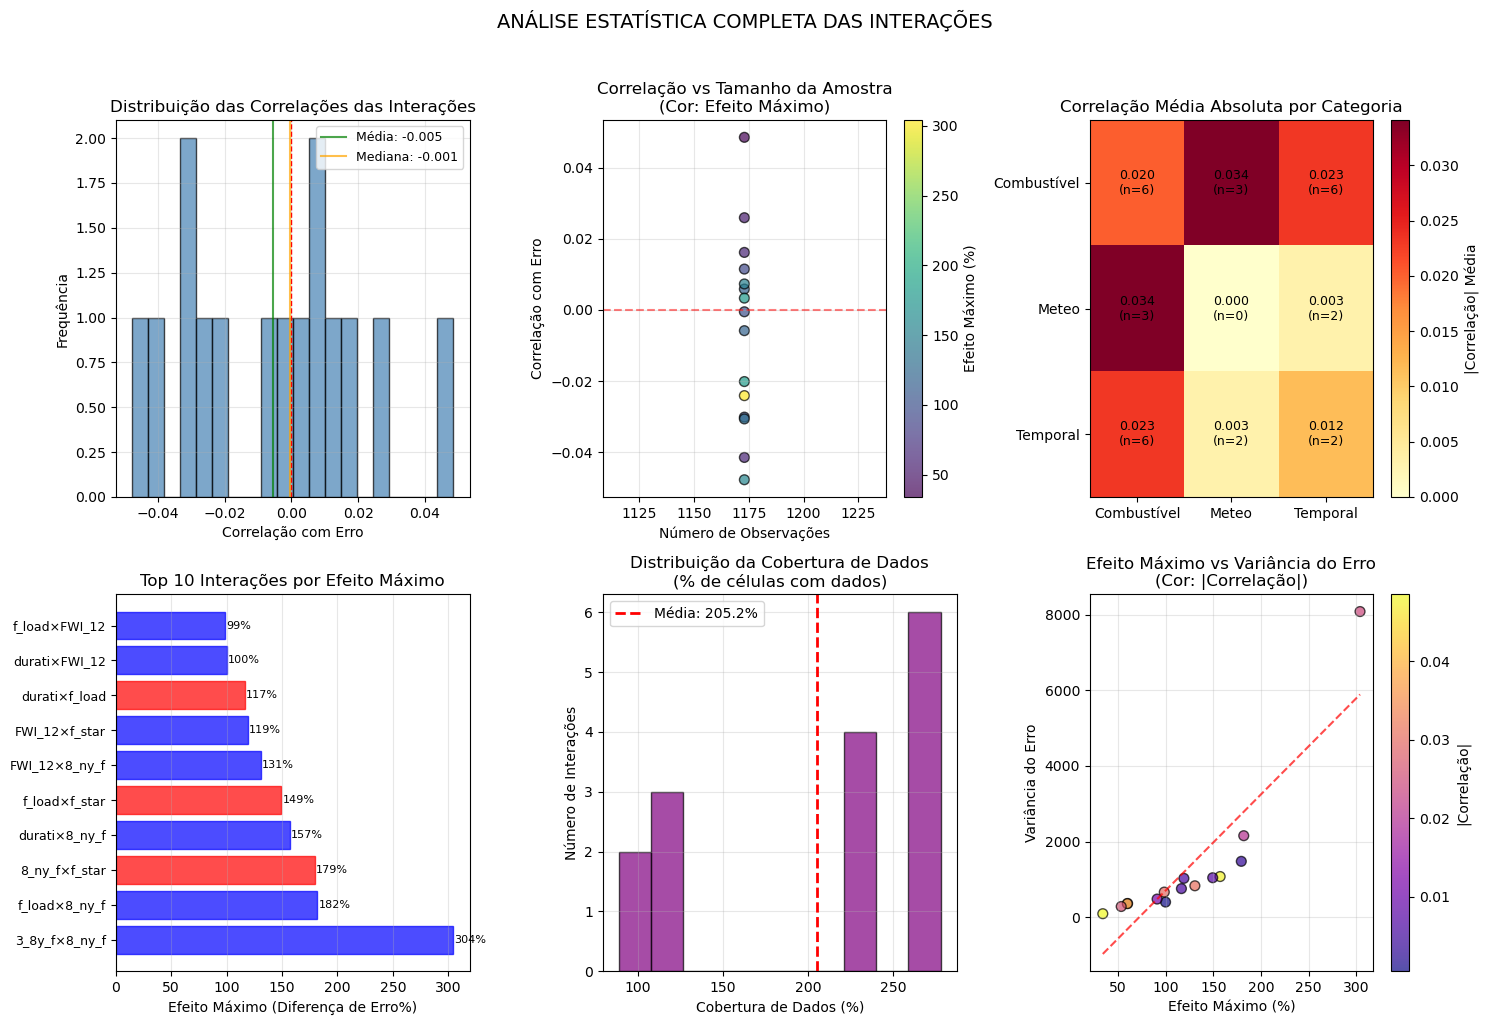


EXPORTANDO RESULTADOS DETALHADOS

Total de interações analisadas: 15
Correlação média absoluta: 0.021
Efeito máximo médio: 122.3%
Variância média do erro: 1271.554

TOP 5 INTERAÇÕES:
--------------------------------------------------------------------------------
1. duration_p      × 3_8y_fir_p     
   Correlação: 0.049 | Efeito Máx: 34.0% | Variância: 91.772 | N: 1173

2. duration_p      × 8_ny_fir_p     
   Correlação: -0.048 | Efeito Máx: 157.2% | Variância: 1074.260 | N: 1173

3. 3_8y_fir_p      × FWI_12h_av     
   Correlação: -0.041 | Efeito Máx: 59.8% | Variância: 357.588 | N: 1173

4. FWI_12h_av      × 8_ny_fir_p     
   Correlação: -0.031 | Efeito Máx: 130.7% | Variância: 829.800 | N: 1173

5. f_load_av       × FWI_12h_av     
   Correlação: -0.030 | Efeito Máx: 98.6% | Variância: 663.094 | N: 1173



In [25]:
def analyze_all_interactions_with_heatmaps(df):
    """
    Análise completa de TODAS as interações entre pares de variáveis preditoras
    com heatmaps individuais para cada par
    """
    print("=" * 80)
    print("ANÁLISE COMPLETA DE TODAS AS INTERAÇÕES COM HEATMAPS")
    print("=" * 80)
    
    # Variáveis preditoras
    predictor_vars = [
        'duration_p', '3_8y_fir_p', 'sW_100_p_av', 
        'f_load_av', 'FWI_12h_av',  
        '8_ny_fir_p', 'f_start'
    ]
    
    # Filtrar apenas variáveis presentes
    predictor_vars = [v for v in predictor_vars if v in df.columns]
    
    if not predictor_vars:
        print("Nenhuma variável preditora encontrada no dataframe")
        return
    
    print(f"Variáveis preditoras disponíveis: {predictor_vars}")
    
    # Gerar todas as combinações possíveis
    import itertools
    all_pairs = list(itertools.combinations(predictor_vars, 2))
    n_pairs = len(all_pairs)
    
    print(f"Número total de combinações: {n_pairs}")
    
    # Calcular resultados para cada par
    interaction_results = []
    
    print("\nCalculando interações para todos os pares...")
    
    for idx, (var1, var2) in enumerate(all_pairs, 1):
        print(f"  Processando {idx}/{n_pairs}: {var1} × {var2}", end='\r')
        
        # Verificar se há dados suficientes
        valid_data = df[[var1, var2, 'Error_p_ab', 'ros_p_log', 'PredROS_lo']].dropna()
        if len(valid_data) < 5:
            continue
        
        try:
            # 1. Correlação do termo de interação com erro
            var1_std = (valid_data[var1] - valid_data[var1].mean()) / valid_data[var1].std()
            var2_std = (valid_data[var2] - valid_data[var2].mean()) / valid_data[var2].std()
            interaction_term = var1_std * var2_std
            corr_with_error = interaction_term.corr(valid_data['Error_p_ab'])
            
            # 2. Preparar dados para heatmap
            n_bins = 5  # 3x3 grid para todos os heatmaps
            x_bins = pd.qcut(valid_data[var1], q=n_bins, duplicates='drop')
            y_bins = pd.qcut(valid_data[var2], q=n_bins, duplicates='drop')
            
            # Calcular métricas para cada célula
            error_matrix = np.full((n_bins, n_bins), np.nan)
            ros_matrix = np.full((n_bins, n_bins), np.nan)
            pred_matrix = np.full((n_bins, n_bins), np.nan)
            count_matrix = np.zeros((n_bins, n_bins))
            
            for i, x_bin in enumerate(x_bins.cat.categories):
                for j, y_bin in enumerate(y_bins.cat.categories):
                    mask = (x_bins == x_bin) & (y_bins == y_bin)
                    if mask.sum() > 0:
                        cell_data = valid_data[mask]
                        error_matrix[i, j] = cell_data['Error_p_ab'].mean()
                        ros_matrix[i, j] = cell_data['ros_p_log'].mean()
                        pred_matrix[i, j] = cell_data['PredROS_lo'].mean()
                        count_matrix[i, j] = mask.sum()
            
            # 3. Calcular estatísticas
            error_variance = np.nanvar(error_matrix)
            if np.sum(~np.isnan(error_matrix)) > 1:
                max_effect = np.nanmax(error_matrix) - np.nanmin(error_matrix)
            else:
                max_effect = np.nan
            
            # Salvar resultados
            interaction_results.append({
                'var1': var1,
                'var2': var2,
                'correlation': corr_with_error,
                'abs_correlation': abs(corr_with_error),
                'error_variance': error_variance,
                'max_effect': max_effect,
                'n_obs': len(valid_data),
                'n_cells_with_data': np.sum(count_matrix > 0),
                'x_bins': x_bins,
                'y_bins': y_bins,
                'error_matrix': error_matrix,
                'ros_matrix': ros_matrix,
                'pred_matrix': pred_matrix,
                'count_matrix': count_matrix
            })
            
        except Exception as e:
            continue
    
    print("\n" + "=" * 80)
    
    if not interaction_results:
        print("Nenhuma interação válida encontrada.")
        return
    
    # Criar DataFrame com resultados
    results_df = pd.DataFrame(interaction_results)
    
    # Mostrar estatísticas resumidas
    print(f"\nInterações válidas encontradas: {len(results_df)}")
    print(f"Média de observações por par: {results_df['n_obs'].mean():.0f}")
    print(f"Média de células com dados: {results_df['n_cells_with_data'].mean():.1f}")
    
    # HEATMAPS DETALHADOS PARA TODAS AS INTERAÇÕES
    print("\n" + "=" * 80)
    print("GERANDO HEATMAPS PARA TODAS AS INTERAÇÕES")
    print("=" * 80)
    
    # Organizar por número de linhas e colunas
    n_interactions = len(results_df)
    
    # Calcular layout ideal
    if n_interactions <= 9:
        n_cols = min(3, n_interactions)
        n_rows = int(np.ceil(n_interactions / n_cols))
    elif n_interactions <= 20:
        n_cols = 4
        n_rows = int(np.ceil(n_interactions / n_cols))
    else:
        n_cols = 5
        n_rows = int(np.ceil(n_interactions / n_cols))
    
    print(f"\nCriando {n_rows}x{n_cols} grid com {n_interactions} heatmaps...")
    
    # Criar figura com subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3.5))
    
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    # Ordenar interações por correlação absoluta
    results_sorted = results_df.sort_values('abs_correlation', ascending=False)
    
    # Gerar heatmap para cada interação
    heatmap_idx = 0
    
    for row in range(n_rows):
        for col in range(n_cols):
            if heatmap_idx >= len(results_sorted):
                # Remover eixo vazio
                fig.delaxes(axes[row, col])
                continue
            
            ax = axes[row, col]
            interaction = results_sorted.iloc[heatmap_idx]
            var1, var2 = interaction['var1'], interaction['var2']
            
            # Obter matrizes
            error_matrix = interaction['error_matrix']
            count_matrix = interaction['count_matrix']
            x_bins = interaction['x_bins']
            y_bins = interaction['y_bins']
            
            # Plot heatmap
            if np.sum(~np.isnan(error_matrix)) > 0:
                # Determinar range de cores
                vmin = np.nanmin(error_matrix) * 0.9
                vmax = np.nanmax(error_matrix) * 1.1
                
                im = ax.imshow(error_matrix, cmap='YlOrRd', aspect='auto', 
                              vmin=vmin, vmax=vmax)
                
                # Configurar ticks
                x_labels = []
                for cat in x_bins.cat.categories:
                    if hasattr(cat, 'left') and hasattr(cat, 'right'):
                        label = f'{cat.left:.1f}-\n{cat.right:.1f}'
                        x_labels.append(label)
                    else:
                        x_labels.append(str(cat)[:10])
                
                y_labels = []
                for cat in y_bins.cat.categories:
                    if hasattr(cat, 'left') and hasattr(cat, 'right'):
                        label = f'{cat.left:.1f}-\n{cat.right:.1f}'
                        y_labels.append(label)
                    else:
                        y_labels.append(str(cat)[:10])
                
                ax.set_xticks(range(len(x_labels)))
                ax.set_yticks(range(len(y_labels)))
                ax.set_xticklabels(x_labels, fontsize=7, rotation=0)
                ax.set_yticklabels(y_labels, fontsize=7)
                
                # Adicionar valores nas células
                for i in range(error_matrix.shape[0]):
                    for j in range(error_matrix.shape[1]):
                        if not np.isnan(error_matrix[i, j]) and count_matrix[i, j] > 0:
                            # Escolher cor do texto baseado no fundo
                            cell_value = error_matrix[i, j]
                            text_color = 'white' if cell_value > (vmin + vmax) / 2 else 'black'
                            
                            ax.text(j, i, f'{cell_value:.0f}%\nn={int(count_matrix[i, j])}', 
                                   ha="center", va="center", color=text_color, fontsize=6)
                
                # Título
                title = f'{var1[:8]}×{var2[:8]}\nCorr: {interaction["correlation"]:.2f}'
                ax.set_title(title, fontsize=9, pad=3)
                
                # Adicionar labels aos eixos
                ax.set_xlabel(var1[:12], fontsize=8, labelpad=2)
                ax.set_ylabel(var2[:12], fontsize=8, labelpad=2)
                
            else:
                ax.text(0.5, 0.5, 'Sem dados\nsuficientes', 
                       ha='center', va='center', transform=ax.transAxes, fontsize=9)
                ax.set_title(f'{var1[:8]}×{var2[:8]}', fontsize=9)
            
            heatmap_idx += 1
    
    # Adicionar uma única colorbar para toda a figura
    if len(results_sorted) > 0:
        # Encontrar a última imagem não vazia
        last_im = None
        for row in range(n_rows):
            for col in range(n_cols):
                if row * n_cols + col < len(results_sorted):
                    last_im = axes[row, col].images[0] if axes[row, col].images else None
        
        if last_im is not None:
            # Criar eixo para a colorbar
            cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
            cbar = fig.colorbar(last_im, cax=cbar_ax)
            cbar.set_label('Erro Absoluto Médio (%)', fontsize=10)
    
    plt.suptitle(f'HEATMAPS DE TODAS AS INTERAÇÕES ({len(results_df)} pares)\n'
                 f'Cada célula mostra: Erro Médio% (n=amostras)', 
                 fontsize=12, y=0.98)
    plt.tight_layout(rect=[0, 0, 0.9, 0.96])  # Deixar espaço para a colorbar
    plt.show()
    
    # HEATMAPS ADICIONAIS: ROS Observado vs Predito
    print("\n" + "=" * 80)
    print("HEATMAPS ADICIONAIS: ROS OBSERVADO vs PREDITO")
    print("=" * 80)
    
    # Selecionar top 9 interações para análise adicional
    top_9 = results_sorted.head(9)
    
    if len(top_9) > 0:
        fig2, axes2 = plt.subplots(3, 3, figsize=(15, 12))
        axes2 = axes2.flatten()
        
        for idx, (_, interaction) in enumerate(top_9.iterrows()):
            if idx < 9:
                ax1 = axes2[idx]
                var1, var2 = interaction['var1'], interaction['var2']
                
                # Dados
                ros_matrix = interaction['ros_matrix']
                pred_matrix = interaction['pred_matrix']
                error_matrix = interaction['error_matrix']
                count_matrix = interaction['count_matrix']
                x_bins = interaction['x_bins']
                y_bins = interaction['y_bins']
                
                # Criar subplots dentro de cada célula
                from mpl_toolkits.axes_grid1.inset_locator import inset_axes
                
                # Plot erro como heatmap principal
                im1 = ax1.imshow(error_matrix, cmap='YlOrRd', aspect='auto', alpha=0.7)
                
                # Adicionar valores ROS observado
                for i in range(ros_matrix.shape[0]):
                    for j in range(ros_matrix.shape[1]):
                        if not np.isnan(ros_matrix[i, j]) and count_matrix[i, j] > 0:
                            # Formatar ROS
                            ros_text = f'O:{ros_matrix[i, j]:.0f}'
                            pred_text = f'P:{pred_matrix[i, j]:.0f}'
                            
                            # Posicionar textos
                            ax1.text(j, i - 0.2, ros_text, ha='center', va='center', 
                                    fontsize=6, color='darkblue', fontweight='bold')
                            ax1.text(j, i + 0.2, pred_text, ha='center', va='center', 
                                    fontsize=6, color='darkgreen', fontweight='bold')
                
                # Configurar ticks
                x_labels = []
                for cat in x_bins.cat.categories:
                    if hasattr(cat, 'left') and hasattr(cat, 'right'):
                        x_labels.append(f'{cat.left:.0f}-\n{cat.right:.0f}')
                    else:
                        x_labels.append(str(cat)[:8])
                
                y_labels = []
                for cat in y_bins.cat.categories:
                    if hasattr(cat, 'left') and hasattr(cat, 'right'):
                        y_labels.append(f'{cat.left:.0f}-\n{cat.right:.0f}')
                    else:
                        y_labels.append(str(cat)[:8])
                
                ax1.set_xticks(range(len(x_labels)))
                ax1.set_yticks(range(len(y_labels)))
                ax1.set_xticklabels(x_labels, fontsize=7)
                ax1.set_yticklabels(y_labels, fontsize=7)
                
                ax1.set_xlabel(var1[:10], fontsize=8)
                ax1.set_ylabel(var2[:10], fontsize=8)
                
                title = f'{var1[:6]}×{var2[:6]}\nCorr: {interaction["correlation"]:.2f}'
                ax1.set_title(title, fontsize=9)
                
                # Adicionar mini gráfico de dispersão como inset
                if interaction['n_obs'] > 10:
                    # Calcular dados para scatter plot
                    valid_data = df[[var1, var2, 'ros_p_log', 'PredROS_lo']].dropna().sample(min(50, interaction['n_obs']))
                    
                    inset_ax = inset_axes(ax1, width="30%", height="30%", loc='upper right',
                                         bbox_to_anchor=(0, 0, 1, 1), bbox_transform=ax1.transAxes)
                    
                    # Scatter plot com cores baseadas no erro
                    scatter = inset_ax.scatter(valid_data[var1], valid_data[var2], 
                                              c=valid_data['ros_p_log'] - valid_data['PredROS_lo'],
                                              cmap='RdBu', s=20, alpha=0.6, 
                                              vmin=-100, vmax=100)
                    
                    inset_ax.set_xlabel('', fontsize=5)
                    inset_ax.set_ylabel('', fontsize=5)
                    inset_ax.tick_params(labelsize=5)
                    inset_ax.set_title('Resíduo ROS', fontsize=6)
        
        plt.suptitle('HEATMAPS DETALHADOS: Erro% com valores ROS (O:Observado, P:Predito)\n'
                     'Cores do fundo: Erro Absoluto Médio%', fontsize=12, y=0.98)
        plt.tight_layout()
        plt.show()
    
    # ANÁLISE ESTATÍSTICA DAS INTERAÇÕES
    print("\n" + "=" * 80)
    print("ANÁLISE ESTATÍSTICA DAS INTERAÇÕES")
    print("=" * 80)
    
    # Criar figura com análise estatística
    fig3, axes3 = plt.subplots(2, 3, figsize=(15, 10))
    
    # 1. Distribuição das correlações
    axes3[0, 0].hist(results_df['correlation'], bins=20, alpha=0.7, 
                     color='steelblue', edgecolor='black')
    axes3[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=1)
    axes3[0, 0].set_xlabel('Correlação com Erro')
    axes3[0, 0].set_ylabel('Frequência')
    axes3[0, 0].set_title('Distribuição das Correlações das Interações')
    axes3[0, 0].grid(True, alpha=0.3)
    
    # Adicionar estatísticas
    mean_corr = results_df['correlation'].mean()
    median_corr = results_df['correlation'].median()
    axes3[0, 0].axvline(x=mean_corr, color='green', linestyle='-', linewidth=1.5, alpha=0.7, label=f'Média: {mean_corr:.3f}')
    axes3[0, 0].axvline(x=median_corr, color='orange', linestyle='-', linewidth=1.5, alpha=0.7, label=f'Mediana: {median_corr:.3f}')
    axes3[0, 0].legend(fontsize=9)
    
    # 2. Correlação vs Número de Observações
    scatter1 = axes3[0, 1].scatter(results_df['n_obs'], results_df['correlation'], 
                                   c=results_df['max_effect'], cmap='viridis', 
                                   s=50, alpha=0.7, edgecolors='black')
    axes3[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes3[0, 1].set_xlabel('Número de Observações')
    axes3[0, 1].set_ylabel('Correlação com Erro')
    axes3[0, 1].set_title('Correlação vs Tamanho da Amostra\n(Cor: Efeito Máximo)')
    axes3[0, 1].grid(True, alpha=0.3)
    plt.colorbar(scatter1, ax=axes3[0, 1], label='Efeito Máximo (%)')
    
    # 3. Matriz de calor de correlações médias por categoria
    # Definir categorias de variáveis
    var_categories = {}
    for var in predictor_vars:
        if 'wv' in var or 'rh' in var or 'FWI' in var or 'wdi' in var:
            var_categories[var] = 'Meteo'
        elif 'fir' in var or 'load' in var:
            var_categories[var] = 'Combustível'
        elif 'duration' in var or 'start' in var:
            var_categories[var] = 'Temporal'
        else:
            var_categories[var] = 'Outro'
    
    # Calcular correlações médias por categoria
    categories = sorted(set(var_categories.values()))
    cat_matrix = pd.DataFrame(0.0, index=categories, columns=categories)
    cat_counts = pd.DataFrame(0, index=categories, columns=categories)
    
    for _, row in results_df.iterrows():
        cat1 = var_categories[row['var1']]
        cat2 = var_categories[row['var2']]
        
        # Ordenar para manter matriz simétrica
        cats = sorted([cat1, cat2])
        cat_matrix.loc[cats[0], cats[1]] += abs(row['correlation'])
        cat_matrix.loc[cats[1], cats[0]] += abs(row['correlation'])
        cat_counts.loc[cats[0], cats[1]] += 1
        cat_counts.loc[cats[1], cats[0]] += 1
    
    # Calcular médias
    for cat1 in categories:
        for cat2 in categories:
            if cat_counts.loc[cat1, cat2] > 0:
                cat_matrix.loc[cat1, cat2] /= cat_counts.loc[cat1, cat2]
    
    # Plot
    im3 = axes3[0, 2].imshow(cat_matrix.values, cmap='YlOrRd', aspect='auto')
    axes3[0, 2].set_xticks(range(len(categories)))
    axes3[0, 2].set_yticks(range(len(categories)))
    axes3[0, 2].set_xticklabels(categories, fontsize=10)
    axes3[0, 2].set_yticklabels(categories, fontsize=10)
    axes3[0, 2].set_title('Correlação Média Absoluta por Categoria')
    
    # Adicionar valores
    for i in range(len(categories)):
        for j in range(len(categories)):
            axes3[0, 2].text(j, i, f'{cat_matrix.iloc[i, j]:.3f}\n(n={cat_counts.iloc[i, j]})',
                           ha='center', va='center', color='white' if cat_matrix.iloc[i, j] > 0.15 else 'black',
                           fontsize=9)
    
    plt.colorbar(im3, ax=axes3[0, 2], label='|Correlação| Média')
    
    # 4. Top 10 interações por efeito máximo
    top_10_effect = results_df.sort_values('max_effect', ascending=False).head(10)
    y_pos = np.arange(len(top_10_effect))
    
    bars = axes3[1, 0].barh(y_pos, top_10_effect['max_effect'].values)
    axes3[1, 0].set_yticks(y_pos)
    axes3[1, 0].set_yticklabels([f"{row['var1'][:6]}×{row['var2'][:6]}" 
                                 for _, row in top_10_effect.iterrows()], fontsize=9)
    axes3[1, 0].set_xlabel('Efeito Máximo (Diferença de Erro%)')
    axes3[1, 0].set_title('Top 10 Interações por Efeito Máximo')
    axes3[1, 0].grid(True, alpha=0.3, axis='x')
    
    # Colorir barras baseado na correlação
    for bar, corr in zip(bars, top_10_effect['correlation'].values):
        bar.set_color('red' if corr > 0 else 'blue')
        bar.set_alpha(0.7)
    
    # Adicionar valores
    for i, (bar, effect) in enumerate(zip(bars, top_10_effect['max_effect'].values)):
        axes3[1, 0].text(effect + 1, bar.get_y() + bar.get_height()/2, 
                        f'{effect:.0f}%', va='center', fontsize=8)
    
    # 5. Densidade de dados por interação
    coverage_data = []
    for _, row in results_df.iterrows():
        coverage = row['n_cells_with_data'] / 9 * 100  # 9 células totais (3x3)
        coverage_data.append(coverage)
    
    axes3[1, 1].hist(coverage_data, bins=10, alpha=0.7, color='purple', edgecolor='black')
    axes3[1, 1].set_xlabel('Cobertura de Dados (%)')
    axes3[1, 1].set_ylabel('Número de Interações')
    axes3[1, 1].set_title('Distribuição da Cobertura de Dados\n(% de células com dados)')
    axes3[1, 1].grid(True, alpha=0.3)
    
    # Adicionar linha da média
    mean_coverage = np.mean(coverage_data)
    axes3[1, 1].axvline(x=mean_coverage, color='red', linestyle='--', 
                        linewidth=2, label=f'Média: {mean_coverage:.1f}%')
    axes3[1, 1].legend()
    
    # 6. Relação entre efeito máximo e variância
    scatter3 = axes3[1, 2].scatter(results_df['max_effect'], results_df['error_variance'],
                                   c=results_df['abs_correlation'], cmap='plasma',
                                   s=50, alpha=0.7, edgecolors='black')
    axes3[1, 2].set_xlabel('Efeito Máximo (%)')
    axes3[1, 2].set_ylabel('Variância do Erro')
    axes3[1, 2].set_title('Efeito Máximo vs Variância do Erro\n(Cor: |Correlação|)')
    axes3[1, 2].grid(True, alpha=0.3)
    plt.colorbar(scatter3, ax=axes3[1, 2], label='|Correlação|')
    
    # Adicionar linha de tendência
    if len(results_df) > 2:
        x = results_df['max_effect'].dropna()
        y = results_df['error_variance'].dropna()
        if len(x) > 1 and len(y) > 1:
            z = np.polyfit(x, y, 1)
            p = np.poly1d(z)
            x_range = np.linspace(x.min(), x.max(), 100)
            axes3[1, 2].plot(x_range, p(x_range), 'r--', alpha=0.7, linewidth=1.5)
    
    plt.suptitle('ANÁLISE ESTATÍSTICA COMPLETA DAS INTERAÇÕES', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # EXPORTAR RESULTADOS
    print("\n" + "=" * 80)
    print("EXPORTANDO RESULTADOS DETALHADOS")
    print("=" * 80)
    
    # Criar DataFrame detalhado para exportação
    export_df = results_df.copy()
    
    # Remover objetos não serializáveis
    export_df = export_df.drop(['x_bins', 'y_bins', 'error_matrix', 
                                'ros_matrix', 'pred_matrix', 'count_matrix'], axis=1)
    
    # Adicionar informações adicionais
    export_df['interaction'] = export_df.apply(lambda x: f"{x['var1']}×{x['var2']}", axis=1)
    export_df['rank_correlation'] = export_df['abs_correlation'].rank(ascending=False)
    export_df['rank_effect'] = export_df['max_effect'].rank(ascending=False)
    export_df['rank_variance'] = export_df['error_variance'].rank(ascending=False)
    
    # Ordenar por correlação absoluta
    export_df = export_df.sort_values('abs_correlation', ascending=False).reset_index(drop=True)
    
    # Mostrar resumo
    print(f"\nTotal de interações analisadas: {len(export_df)}")
    print(f"Correlação média absoluta: {export_df['abs_correlation'].mean():.3f}")
    print(f"Efeito máximo médio: {export_df['max_effect'].mean():.1f}%")
    print(f"Variância média do erro: {export_df['error_variance'].mean():.3f}")
    
    print("\nTOP 5 INTERAÇÕES:")
    print("-" * 80)
    for i, row in export_df.head(5).iterrows():
        print(f"{i+1}. {row['var1']:15s} × {row['var2']:15s}")
        print(f"   Correlação: {row['correlation']:.3f} | "
              f"Efeito Máx: {row['max_effect']:.1f}% | "
              f"Variância: {row['error_variance']:.3f} | "
              f"N: {row['n_obs']}")
        print()
    
    return export_df

# USO:
# 1. Execute a análise completa
interaction_results = analyze_all_interactions_with_heatmaps(df)


ANÁLISE DE CLUSTER PARA GRANDES ERROS
Threshold para grandes erros: 80.7% (percentil 75)

Distribuição:
  Total observações: 1173
  Grandes erros (> 80.7%): 293 (25.0%)
  Baixos erros: 880 (75.0%)

Variáveis usadas para clustering (8):
  • duration_p
  • 3_8y_fir_p
  • f_load_av
  • FWI_12h_av
  • 8_ny_fir_p
  • f_start
  • ros_p_log
  • PredROS_lo

DETERMINANDO NÚMERO ÓTIMO DE CLUSTERS


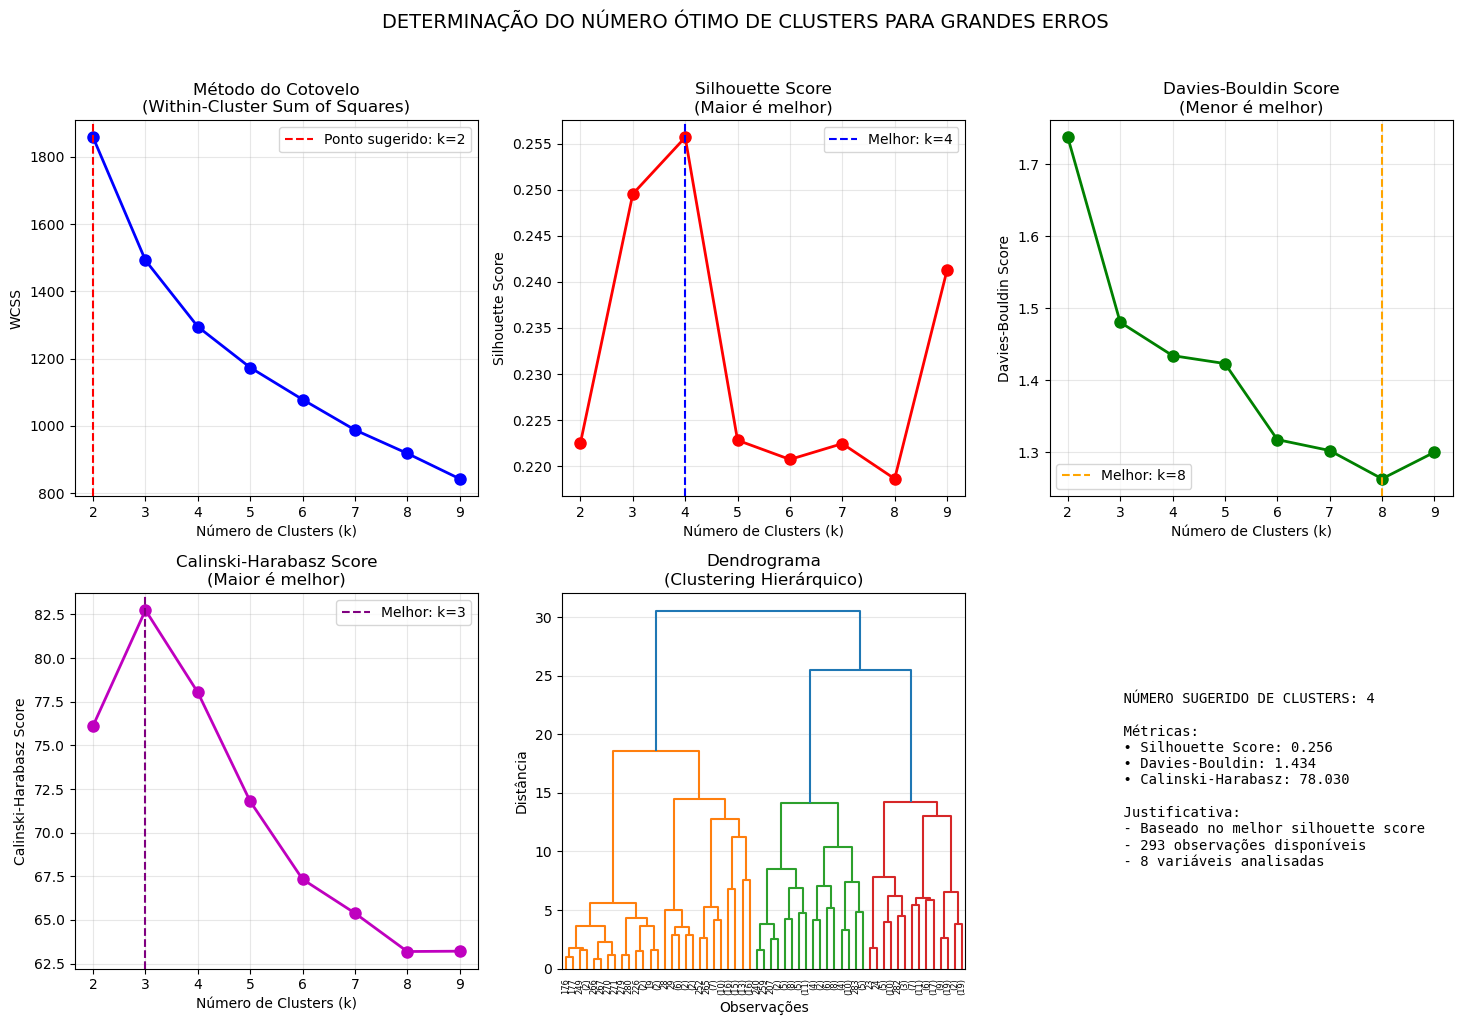


APLICANDO K-MEANS COM 4 CLUSTERS

Distribuição dos clusters:
  Cluster 0: 135 observações (46.1%)
  Cluster 1: 38 observações (13.0%)
  Cluster 2: 52 observações (17.7%)
  Cluster 3: 68 observações (23.2%)

CARACTERIZAÇÃO DOS CLUSTERS


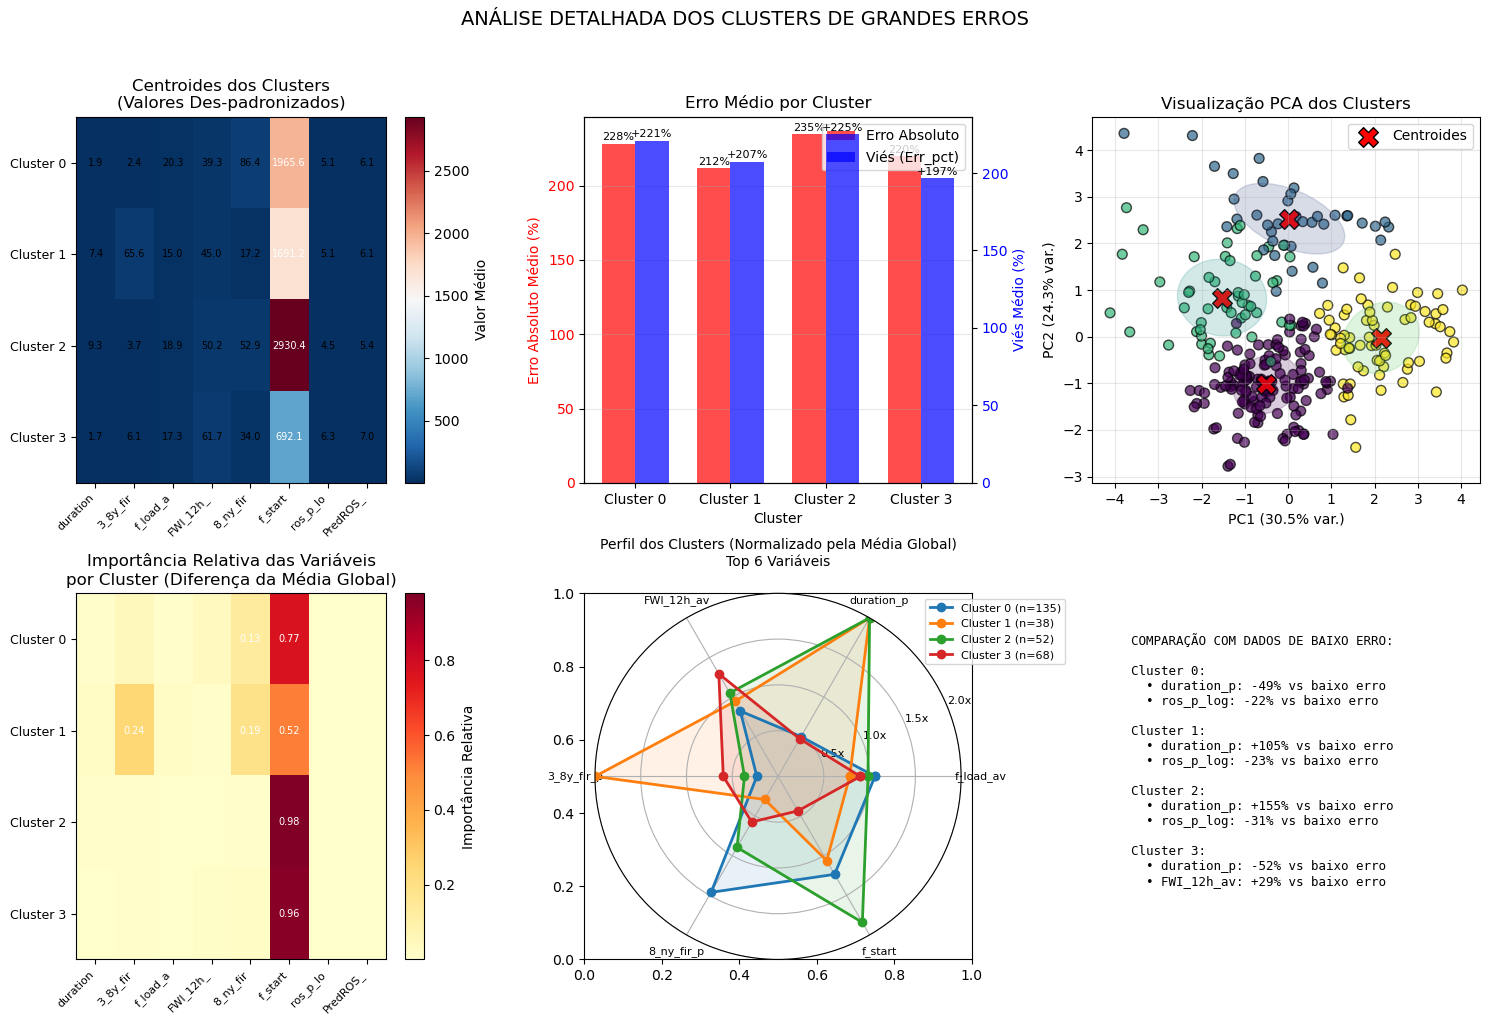


PERFIL DETALHADO DE CADA CLUSTER

CLUSTER 0
Número de observações: 135 (46.1% dos grandes erros)
Erro absoluto médio: 228.2%
Viés médio (Err_pct): +220.8%

CARACTERÍSTICAS PRINCIPAIS (vs média global):
  • duration_p: 1.85 (MENOR 50%)
  • 3_8y_fir_p: 2.35 (MENOR 77%)
  • FWI_12h_av: 39.34 (MENOR 17%)
  • 8_ny_fir_p: 86.43 (MAIOR 46%)
  • f_start: 1965.60 (MAIOR 24%)

CONDIÇÕES EXTREMAS:
  • 8_ny_fir_p: >75º percentil em 81/135 observações

TIPO PREDOMINANTE DE ERRO:
  • SUPERESTIMAÇÃO (modelo prevê valores muito altos)

CLUSTER 1
Número de observações: 38 (13.0% dos grandes erros)
Erro absoluto médio: 211.6%
Viés médio (Err_pct): +207.4%

CARACTERÍSTICAS PRINCIPAIS (vs média global):
  • duration_p: 7.44 (MAIOR 102%)
  • 3_8y_fir_p: 65.59 (MAIOR 547%)
  • f_load_av: 15.04 (MENOR 22%)
  • 8_ny_fir_p: 17.21 (MENOR 71%)

CONDIÇÕES EXTREMAS:
  • duration_p: >75º percentil em 25/38 observações
  • 3_8y_fir_p: >75º percentil em 38/38 observações

TIPO PREDOMINANTE DE ERRO:
  • SUPERESTIMAÇÃ

In [26]:
def analyze_error_clusters(df):
    """
    Análise de cluster para identificar padrões nos grandes erros do modelo
    """
    print("=" * 80)
    print("ANÁLISE DE CLUSTER PARA GRANDES ERROS")
    print("=" * 80)
    
    # Configurar backend para evitar warning
    import warnings
    warnings.filterwarnings('ignore')
    
    # Preparar dados
    df_clean = df.copy()
    
    # Definir threshold para "grandes erros"
    error_threshold = df['Error_p_ab'].quantile(0.75)  # Top 25% maiores erros
    print(f"Threshold para grandes erros: {error_threshold:.1f}% (percentil 75)")
    
    df_clean['high_error'] = df_clean['Error_p_ab'] > error_threshold
    high_error_data = df_clean[df_clean['high_error']].copy()
    low_error_data = df_clean[~df_clean['high_error']].copy()
    
    print(f"\nDistribuição:")
    print(f"  Total observações: {len(df_clean)}")
    print(f"  Grandes erros (> {error_threshold:.1f}%): {len(high_error_data)} ({len(high_error_data)/len(df_clean)*100:.1f}%)")
    print(f"  Baixos erros: {len(low_error_data)} ({len(low_error_data)/len(df_clean)*100:.1f}%)")
    
    # Variáveis para análise de cluster
    cluster_vars = [
        'duration_p', '3_8y_fir_p', 'sW_100_p_av', 
        'f_load_av', 'FWI_12h_av',  
        '8_ny_fir_p', 'f_start', 
        'ros_p_log', 'PredROS_lo'
    ]
    
    # Filtrar variáveis presentes
    cluster_vars = [v for v in cluster_vars if v in df_clean.columns]
    
    # Preparar dados para clustering
    X = high_error_data[cluster_vars].copy()
    
    # Tratar valores faltantes
    X = X.fillna(X.mean())
    
    # Padronizar variáveis
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    if len(X_scaled) < 5:
        print("\nAVISO: Poucas observações para análise de cluster.")
        return
    
    print(f"\nVariáveis usadas para clustering ({len(cluster_vars)}):")
    for var in cluster_vars:
        print(f"  • {var}")
    
    # 1. Determinar número ótimo de clusters
    print("\n" + "=" * 80)
    print("DETERMINANDO NÚMERO ÓTIMO DE CLUSTERS")
    print("=" * 80)
    
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
    
    # Testar diferentes números de clusters
    k_range = range(2, min(10, len(X_scaled) // 5 + 1))
    wcss = []  # Within-cluster sum of squares
    silhouette_scores = []
    db_scores = []
    ch_scores = []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        
        wcss.append(kmeans.inertia_)
        
        if len(X_scaled) > k:
            labels = kmeans.labels_
            silhouette_scores.append(silhouette_score(X_scaled, labels))
            db_scores.append(davies_bouldin_score(X_scaled, labels))
            ch_scores.append(calinski_harabasz_score(X_scaled, labels))
        else:
            silhouette_scores.append(np.nan)
            db_scores.append(np.nan)
            ch_scores.append(np.nan)
    
    # Plot métricas de avaliação
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # 1. Método do Cotovelo (WCSS)
    axes[0, 0].plot(k_range, wcss, 'bo-', linewidth=2, markersize=8)
    axes[0, 0].set_xlabel('Número de Clusters (k)')
    axes[0, 0].set_ylabel('WCSS')
    axes[0, 0].set_title('Método do Cotovelo\n(Within-Cluster Sum of Squares)')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Calcular ponto de curvatura
    if len(wcss) >= 3:
        diffs = np.diff(wcss)
        diffs2 = np.diff(diffs)
        if len(diffs2) > 0:
            elbow_point = np.argmax(diffs2) + 2
            axes[0, 0].axvline(x=elbow_point, color='red', linestyle='--', 
                              label=f'Ponto sugerido: k={elbow_point}')
            axes[0, 0].legend()
    
    # 2. Silhouette Score
    axes[0, 1].plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
    axes[0, 1].set_xlabel('Número de Clusters (k)')
    axes[0, 1].set_ylabel('Silhouette Score')
    axes[0, 1].set_title('Silhouette Score\n(Maior é melhor)')
    axes[0, 1].grid(True, alpha=0.3)
    
    if not all(np.isnan(silhouette_scores)):
        best_k_sil = k_range[np.nanargmax(silhouette_scores)]
        axes[0, 1].axvline(x=best_k_sil, color='blue', linestyle='--', 
                          label=f'Melhor: k={best_k_sil}')
        axes[0, 1].legend()
    
    # 3. Davies-Bouldin Score
    axes[0, 2].plot(k_range, db_scores, 'go-', linewidth=2, markersize=8)
    axes[0, 2].set_xlabel('Número de Clusters (k)')
    axes[0, 2].set_ylabel('Davies-Bouldin Score')
    axes[0, 2].set_title('Davies-Bouldin Score\n(Menor é melhor)')
    axes[0, 2].grid(True, alpha=0.3)
    
    if not all(np.isnan(db_scores)):
        best_k_db = k_range[np.nanargmin(db_scores)]
        axes[0, 2].axvline(x=best_k_db, color='orange', linestyle='--', 
                          label=f'Melhor: k={best_k_db}')
        axes[0, 2].legend()
    
    # 4. Calinski-Harabasz Score
    axes[1, 0].plot(k_range, ch_scores, 'mo-', linewidth=2, markersize=8)
    axes[1, 0].set_xlabel('Número de Clusters (k)')
    axes[1, 0].set_ylabel('Calinski-Harabasz Score')
    axes[1, 0].set_title('Calinski-Harabasz Score\n(Maior é melhor)')
    axes[1, 0].grid(True, alpha=0.3)
    
    if not all(np.isnan(ch_scores)):
        best_k_ch = k_range[np.nanargmax(ch_scores)]
        axes[1, 0].axvline(x=best_k_ch, color='purple', linestyle='--', 
                          label=f'Melhor: k={best_k_ch}')
        axes[1, 0].legend()
    
    # 5. Dendrograma (para visualização hierárquica)
    from scipy.cluster.hierarchy import dendrogram, linkage
    
    try:
        linked = linkage(X_scaled, method='ward')
        
        axes[1, 1].set_title('Dendrograma\n(Clustering Hierárquico)')
        dendrogram(linked, ax=axes[1, 1], truncate_mode='level', p=5)
        axes[1, 1].set_xlabel('Observações')
        axes[1, 1].set_ylabel('Distância')
        axes[1, 1].grid(True, alpha=0.3, axis='y')
    except:
        axes[1, 1].text(0.5, 0.5, 'Não foi possível\ngerar dendrograma', 
                       ha='center', va='center', transform=axes[1, 1].transAxes)
    
    # 6. Resumo das métricas
    axes[1, 2].axis('off')
    
    # Escolher número de clusters baseado nas métricas
    n_clusters = 3  # Default
    if not all(np.isnan(silhouette_scores)):
        n_clusters = k_range[np.nanargmax(silhouette_scores)]
    
    summary_text = f"""
    NÚMERO SUGERIDO DE CLUSTERS: {n_clusters}
    
    Métricas:
    • Silhouette Score: {silhouette_scores[n_clusters-2]:.3f}
    • Davies-Bouldin: {db_scores[n_clusters-2]:.3f}
    • Calinski-Harabasz: {ch_scores[n_clusters-2]:.3f}
    
    Justificativa:
    - Baseado no melhor silhouette score
    - {len(high_error_data)} observações disponíveis
    - {len(cluster_vars)} variáveis analisadas
    """
    
    axes[1, 2].text(0.1, 0.5, summary_text, fontsize=10, 
                   verticalalignment='center', fontfamily='monospace')
    
    plt.suptitle('DETERMINAÇÃO DO NÚMERO ÓTIMO DE CLUSTERS PARA GRANDES ERROS', 
                 fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # 2. Aplicar K-means com número ótimo de clusters
    print("\n" + "=" * 80)
    print(f"APLICANDO K-MEANS COM {n_clusters} CLUSTERS")
    print("=" * 80)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # Adicionar labels aos dados
    high_error_data['cluster'] = cluster_labels
    
    print(f"\nDistribuição dos clusters:")
    cluster_counts = high_error_data['cluster'].value_counts().sort_index()
    for cluster_id, count in cluster_counts.items():
        percentage = count / len(high_error_data) * 100
        print(f"  Cluster {cluster_id}: {count} observações ({percentage:.1f}%)")
    
    # 3. Análise dos clusters
    print("\n" + "=" * 80)
    print("CARACTERIZAÇÃO DOS CLUSTERS")
    print("=" * 80)
    
    # Calcular estatísticas por cluster
    cluster_stats = {}
    
    for cluster_id in range(n_clusters):
        cluster_data = high_error_data[high_error_data['cluster'] == cluster_id]
        
        stats = {
            'n_obs': len(cluster_data),
            'perc_total': len(cluster_data) / len(high_error_data) * 100
        }
        
        # Estatísticas das variáveis
        for var in cluster_vars:
            stats[f'{var}_mean'] = cluster_data[var].mean()
            stats[f'{var}_std'] = cluster_data[var].std()
            stats[f'{var}_median'] = cluster_data[var].median()
        
        # Estatísticas de erro
        stats['Error_p_ab_mean'] = cluster_data['Error_p_ab'].mean()
        stats['Error_p_ab_max'] = cluster_data['Error_p_ab'].max()
        stats['Err_pct_mean'] = cluster_data['Err_pct'].mean()  # Viés (positivo = superestimação)
        
        cluster_stats[cluster_id] = stats
    
    # Visualização dos clusters
    fig2, axes2 = plt.subplots(2, 3, figsize=(15, 10))
    
    # 1. Centroides dos clusters (heatmap)
    centroids = kmeans.cluster_centers_
    
    # Des-padronizar para interpretação
    centroids_original = scaler.inverse_transform(centroids)
    
    im1 = axes2[0, 0].imshow(centroids_original, cmap='RdBu_r', aspect='auto')
    axes2[0, 0].set_xticks(range(len(cluster_vars)))
    axes2[0, 0].set_yticks(range(n_clusters))
    axes2[0, 0].set_xticklabels([v[:8] for v in cluster_vars], rotation=45, ha='right', fontsize=8)
    axes2[0, 0].set_yticklabels([f'Cluster {i}' for i in range(n_clusters)], fontsize=9)
    axes2[0, 0].set_title('Centroides dos Clusters\n(Valores Des-padronizados)')
    plt.colorbar(im1, ax=axes2[0, 0], label='Valor Médio')
    
    # Adicionar valores
    for i in range(n_clusters):
        for j in range(len(cluster_vars)):
            axes2[0, 0].text(j, i, f'{centroids_original[i, j]:.1f}', 
                            ha='center', va='center', color='white' if abs(centroids_original[i, j]) > np.mean(abs(centroids_original)) else 'black',
                            fontsize=7)
    
    # 2. Erro por cluster
    error_by_cluster = []
    bias_by_cluster = []
    
    for cluster_id in range(n_clusters):
        cluster_data = high_error_data[high_error_data['cluster'] == cluster_id]
        error_by_cluster.append(cluster_data['Error_p_ab'].mean())
        bias_by_cluster.append(cluster_data['Err_pct'].mean())
    
    x = np.arange(n_clusters)
    width = 0.35
    
    bars1 = axes2[0, 1].bar(x - width/2, error_by_cluster, width, label='Erro Absoluto', color='red', alpha=0.7)
    axes2[0, 1].set_xlabel('Cluster')
    axes2[0, 1].set_ylabel('Erro Absoluto Médio (%)', color='red')
    axes2[0, 1].tick_params(axis='y', labelcolor='red')
    axes2[0, 1].set_title('Erro Médio por Cluster')
    axes2[0, 1].set_xticks(x)
    axes2[0, 1].set_xticklabels([f'Cluster {i}' for i in range(n_clusters)])
    axes2[0, 1].grid(True, alpha=0.3, axis='y')
    
    ax2_twin = axes2[0, 1].twinx()
    bars2 = ax2_twin.bar(x + width/2, bias_by_cluster, width, label='Viés (Err_pct)', color='blue', alpha=0.7)
    ax2_twin.set_ylabel('Viés Médio (%)', color='blue')
    ax2_twin.tick_params(axis='y', labelcolor='blue')
    
    # Linhas para legendas combinadas
    lines1, labels1 = axes2[0, 1].get_legend_handles_labels()
    lines2, labels2 = ax2_twin.get_legend_handles_labels()
    axes2[0, 1].legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    # Adicionar valores
    for bar, error in zip(bars1, error_by_cluster):
        height = bar.get_height()
        axes2[0, 1].text(bar.get_x() + bar.get_width()/2., height + 1, 
                        f'{error:.0f}%', ha='center', va='bottom', fontsize=8)
    
    for bar, bias in zip(bars2, bias_by_cluster):
        height = bar.get_height()
        ax2_twin.text(bar.get_x() + bar.get_width()/2., height + (1 if bias >= 0 else -3), 
                     f'{bias:+.0f}%', ha='center', va='bottom' if bias >= 0 else 'top', fontsize=8)
    
    # 3. PCA para visualização 2D dos clusters
    from sklearn.decomposition import PCA
    
    try:
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)
        
        scatter = axes2[0, 2].scatter(X_pca[:, 0], X_pca[:, 1], 
                                     c=cluster_labels, cmap='viridis', 
                                     s=50, alpha=0.7, edgecolors='black')
        axes2[0, 2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var.)')
        axes2[0, 2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var.)')
        axes2[0, 2].set_title('Visualização PCA dos Clusters')
        axes2[0, 2].grid(True, alpha=0.3)
        
        # Adicionar centroides no espaço PCA
        centroids_pca = pca.transform(kmeans.cluster_centers_)
        axes2[0, 2].scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
                           c='red', s=200, marker='X', edgecolors='black', 
                           label='Centroides')
        
        # Adicionar elipses de confiança
        from matplotlib.patches import Ellipse
        for cluster_id in range(n_clusters):
            cluster_points = X_pca[cluster_labels == cluster_id]
            if len(cluster_points) > 2:
                mean = np.mean(cluster_points, axis=0)
                cov = np.cov(cluster_points.T)
                eigvals, eigvecs = np.linalg.eigh(cov)
                angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
                width, height = 2 * np.sqrt(eigvals)
                
                ellipse = Ellipse(xy=mean, width=width, height=height, 
                                 angle=angle, alpha=0.2, color=plt.cm.viridis(cluster_id/n_clusters))
                axes2[0, 2].add_patch(ellipse)
        
        axes2[0, 2].legend()
        
    except Exception as e:
        axes2[0, 2].text(0.5, 0.5, f'Erro no PCA:\n{str(e)[:50]}', 
                        ha='center', va='center', transform=axes2[0, 2].transAxes)
    
    # 4. Variáveis mais importantes para cada cluster
    # Calcular importância baseada na diferença da média global
    global_means = X.mean()
    
    importance_matrix = np.zeros((n_clusters, len(cluster_vars)))
    
    for cluster_id in range(n_clusters):
        cluster_means = high_error_data[high_error_data['cluster'] == cluster_id][cluster_vars].mean()
        importance_matrix[cluster_id] = (cluster_means - global_means).abs().values
    
    # Normalizar por linha
    row_sums = importance_matrix.sum(axis=1, keepdims=True)
    importance_matrix_norm = importance_matrix / row_sums
    
    im2 = axes2[1, 0].imshow(importance_matrix_norm, cmap='YlOrRd', aspect='auto')
    axes2[1, 0].set_xticks(range(len(cluster_vars)))
    axes2[1, 0].set_yticks(range(n_clusters))
    axes2[1, 0].set_xticklabels([v[:8] for v in cluster_vars], rotation=45, ha='right', fontsize=8)
    axes2[1, 0].set_yticklabels([f'Cluster {i}' for i in range(n_clusters)], fontsize=9)
    axes2[1, 0].set_title('Importância Relativa das Variáveis\npor Cluster (Diferença da Média Global)')
    plt.colorbar(im2, ax=axes2[1, 0], label='Importância Relativa')
    
    # Adicionar valores
    for i in range(n_clusters):
        for j in range(len(cluster_vars)):
            if importance_matrix_norm[i, j] > 0.1:  # Apenas valores importantes
                axes2[1, 0].text(j, i, f'{importance_matrix_norm[i, j]:.2f}', 
                                ha='center', va='center', color='white', fontsize=7)
    
    # 5. Perfil dos clusters (radar chart)
    # Selecionar variáveis mais importantes
    top_vars_idx = importance_matrix.sum(axis=0).argsort()[-6:]  # Top 6 variáveis
    top_vars = [cluster_vars[i] for i in top_vars_idx]
    
    # Preparar dados para radar chart
    angles = np.linspace(0, 2 * np.pi, len(top_vars), endpoint=False).tolist()
    angles += angles[:1]  # Fechar o círculo
    
    ax_radar = axes2[1, 1]
    ax_radar = fig2.add_subplot(2, 3, 5, polar=True)
    
    for cluster_id in range(n_clusters):
        cluster_values = []
        for var in top_vars:
            cluster_mean = high_error_data[high_error_data['cluster'] == cluster_id][var].mean()
            global_mean = df_clean[var].mean()
            # Normalizar pela média global
            normalized_value = cluster_mean / global_mean if global_mean != 0 else 1.0
            cluster_values.append(min(normalized_value, 2.0))  # Limitar para melhor visualização
        
        cluster_values += cluster_values[:1]  # Fechar o círculo
        
        ax_radar.plot(angles, cluster_values, 'o-', linewidth=2, 
                     label=f'Cluster {cluster_id} (n={cluster_counts[cluster_id]})')
        ax_radar.fill(angles, cluster_values, alpha=0.1)
    
    ax_radar.set_xticks(angles[:-1])
    ax_radar.set_xticklabels([v[:10] for v in top_vars], fontsize=8)
    ax_radar.set_ylim(0, 2)
    ax_radar.set_yticks([0.5, 1.0, 1.5, 2.0])
    ax_radar.set_yticklabels(['0.5x', '1.0x', '1.5x', '2.0x'], fontsize=8)
    ax_radar.set_title('Perfil dos Clusters (Normalizado pela Média Global)\nTop 6 Variáveis', fontsize=10, pad=20)
    ax_radar.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=8)
    ax_radar.grid(True)
    
    # 6. Comparação com dados de baixo erro
    axes2[1, 2].axis('off')
    
    # Calcular diferenças entre clusters e dados de baixo erro
    comparison_text = "COMPARAÇÃO COM DADOS DE BAIXO ERRO:\n\n"
    
    for cluster_id in range(n_clusters):
        cluster_data = high_error_data[high_error_data['cluster'] == cluster_id]
        
        # Encontrar variáveis mais diferentes
        diff_vars = []
        for var in ['ros_p_log', 'duration_p', 'FWI_12h_av', 'wv100_k_av']:
            if var in cluster_vars:
                cluster_mean = cluster_data[var].mean()
                low_error_mean = low_error_data[var].mean()
                diff_pct = (cluster_mean - low_error_mean) / low_error_mean * 100 if low_error_mean != 0 else 0
                
                if abs(diff_pct) > 20:  # > 20% de diferença
                    diff_vars.append((var, diff_pct))
        
        # Ordenar por diferença absoluta
        diff_vars.sort(key=lambda x: abs(x[1]), reverse=True)
        
        comparison_text += f"Cluster {cluster_id}:\n"
        if diff_vars:
            for var, diff in diff_vars[:3]:  # Top 3 diferenças
                comparison_text += f"  • {var}: {diff:+.0f}% vs baixo erro\n"
        else:
            comparison_text += "  • Nenhuma diferença significativa\n"
        comparison_text += "\n"
    
    axes2[1, 2].text(0.1, 0.5, comparison_text, fontsize=9, 
                    verticalalignment='center', fontfamily='monospace')
    
    plt.suptitle('ANÁLISE DETALHADA DOS CLUSTERS DE GRANDES ERROS', 
                 fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # 4. Perfil detalhado de cada cluster
    print("\n" + "=" * 80)
    print("PERFIL DETALHADO DE CADA CLUSTER")
    print("=" * 80)
    
    for cluster_id in range(n_clusters):
        cluster_data = high_error_data[high_error_data['cluster'] == cluster_id]
        
        print(f"\n{'='*60}")
        print(f"CLUSTER {cluster_id}")
        print(f"{'='*60}")
        print(f"Número de observações: {len(cluster_data)} ({len(cluster_data)/len(high_error_data)*100:.1f}% dos grandes erros)")
        print(f"Erro absoluto médio: {cluster_data['Error_p_ab'].mean():.1f}%")
        print(f"Viés médio (Err_pct): {cluster_data['Err_pct'].mean():+.1f}%")
        
        # Características únicas
        print("\nCARACTERÍSTICAS PRINCIPAIS (vs média global):")
        
        # Calcular diferenças percentuais
        for var in cluster_vars[:6]:  # Apenas primeiras 6 para clareza
            cluster_mean = cluster_data[var].mean()
            global_mean = df_clean[var].mean()
            
            if global_mean != 0:
                diff_pct = (cluster_mean - global_mean) / global_mean * 100
                if abs(diff_pct) > 15:  # Diferenças > 15%
                    direction = "MAIOR" if diff_pct > 0 else "MENOR"
                    print(f"  • {var}: {cluster_mean:.2f} ({direction} {abs(diff_pct):.0f}%)")
        
        # Condições extremas
        print("\nCONDIÇÕES EXTREMAS:")
        extreme_vars = []
        for var in cluster_vars:
            if var in df_clean.columns:
                threshold = df_clean[var].quantile(0.75)
                extreme_count = (cluster_data[var] > threshold).sum()
                if extreme_count / len(cluster_data) > 0.5:  # > 50% em extremos
                    extreme_vars.append(var)
        
        if extreme_vars:
            for var in extreme_vars[:3]:  # Top 3
                print(f"  • {var}: >75º percentil em {len(cluster_data[cluster_data[var] > df_clean[var].quantile(0.75)])}/{len(cluster_data)} observações")
        else:
            print("  • Nenhuma condição extremamente prevalente")
        
        # Distribuição temporal (se disponível)
        if 'year' in df_clean.columns:
            print("\nDISTRIBUIÇÃO TEMPORAL:")
            years = cluster_data['year'].unique()
            if len(years) <= 3:
                print(f"  • Anos: {', '.join(map(str, sorted(years)))}")
            else:
                print(f"  • {len(years)} anos diferentes")
        
        print(f"\nTIPO PREDOMINANTE DE ERRO:")
        mean_bias = cluster_data['Err_pct'].mean()
        if mean_bias > 10:
            print(f"  • SUPERESTIMAÇÃO (modelo prevê valores muito altos)")
        elif mean_bias < -10:
            print(f"  • SUBESTIMAÇÃO (modelo prevê valores muito baixos)")
        else:
            print(f"  • ERRO BALANCEADO (sem viés claro)")
    
    # 5. Recomendações baseadas nos clusters
    print("\n" + "=" * 80)
    print("RECOMENDAÇÕES BASEADAS NA ANÁLISE DE CLUSTERS")
    print("=" * 80)
    
    recommendations = []
    
    for cluster_id in range(n_clusters):
        cluster_data = high_error_data[high_error_data['cluster'] == cluster_id]
        
        # Analisar padrões
        high_wind = False
        low_humidity = False
        high_fwi = False
        long_duration = False
        
        if 'wv100_k_av' in cluster_vars:
            wind_threshold = df_clean['wv100_k_av'].quantile(0.75)
            if (cluster_data['wv100_k_av'] > wind_threshold).mean() > 0.6:
                high_wind = True
        
        if 'rh_2m_av' in cluster_vars:
            humidity_threshold = df_clean['rh_2m_av'].quantile(0.25)
            if (cluster_data['rh_2m_av'] < humidity_threshold).mean() > 0.6:
                low_humidity = True
        
        if 'FWI_12h_av' in cluster_vars:
            fwi_threshold = df_clean['FWI_12h_av'].quantile(0.75)
            if (cluster_data['FWI_12h_av'] > fwi_threshold).mean() > 0.6:
                high_fwi = True
        
        if 'duration_p' in cluster_vars:
            duration_threshold = df_clean['duration_p'].quantile(0.75)
            if (cluster_data['duration_p'] > duration_threshold).mean() > 0.6:
                long_duration = True
        
        # Gerar recomendações
        cluster_recs = []
        
        if high_wind and low_humidity:
            cluster_recs.append("Condições de vento alto + humidade baixa - considerar ajustes específicos para estas condições")
        
        if high_fwi and long_duration:
            cluster_recs.append("Fogo prolongado com alto risco meteorológico - modelo pode não capturar efeitos cumulativos")
        
        if len(cluster_recs) > 0:
            recommendations.append(f"Cluster {cluster_id}: {', '.join(cluster_recs)}")
    
    if recommendations:
        print("\nRecomendações específicas por cluster:")
        for rec in recommendations:
            print(f"  • {rec}")
    else:
        print("\nRecomendações gerais:")
        print("  • Analisar interações não-lineares entre variáveis")
        print("  • Considerar modelos específicos para condições extremas")
        print("  • Revisar tratamento de outliers nos dados de treino")
    
    # Retornar resultados
    results = {
        'high_error_data': high_error_data,
        'low_error_data': low_error_data,
        'cluster_stats': cluster_stats,
        'n_clusters': n_clusters,
        'scaler': scaler,
        'kmeans': kmeans,
        'cluster_vars': cluster_vars
    }
    
    return results

# Função para prever cluster para novas observações
def predict_error_cluster(new_data, cluster_results):
    """
    Prever cluster para novas observações baseado no modelo treinado
    """
    if 'scaler' not in cluster_results or 'kmeans' not in cluster_results:
        print("ERRO: Modelo de cluster não treinado")
        return None
    
    # Preparar dados
    X_new = new_data[cluster_results['cluster_vars']].copy()
    X_new = X_new.fillna(X_new.mean())
    
    # Padronizar
    X_scaled = cluster_results['scaler'].transform(X_new)
    
    # Prever clusters
    clusters = cluster_results['kmeans'].predict(X_scaled)
    
    # Adicionar aos dados
    new_data_with_clusters = new_data.copy()
    new_data_with_clusters['predicted_cluster'] = clusters
    new_data_with_clusters['is_high_error'] = True  # Assumindo que são grandes erros
    
    return new_data_with_clusters

# USO:
# Execute a análise de cluster
cluster_results = analyze_error_clusters(df)

# Se quiser classificar novas observações
if cluster_results:
    # Exemplo: classificar todas as observações
    all_data_with_clusters = predict_error_cluster(df, cluster_results)
    
    if all_data_with_clusters is not None:
        print("\nDistribuição de clusters em todos os dados:")
        print(all_data_with_clusters['predicted_cluster'].value_counts().sort_index())
        